**Set up notebook:**

In [ ]:
#!pip install ipympl

In [ ]:
#Configure Google Drive
from google.colab import drive
drive.mount('/content/drive')

#Path to dataset folder
data_folder = '/content/drive/My Drive/MA/'

Mounted at /content/drive


In [ ]:
# #Upload file locally
# from google.colab import files

# uploaded = files.upload()

In [ ]:
#Import required libraries for this notebook
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.models import model_from_json, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Input
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from google.colab import files
import seaborn as sns
from sklearn.linear_model import LinearRegression
import re
from sklearn.metrics import mean_squared_error
import math

from google.colab import output
output.enable_custom_widget_manager()

pd.set_option('display.max_rows', 200)

**Load dataset:**

In [ ]:
#Read WTG data
signals = 'wind-farm-1-signals-training.csv'
signals_test = 'wind-farm-1-signals-testing.csv'

#Read Signals data for all turbines and set timestamp as index
all_data = pd.concat([pd.read_csv(data_folder + signals, delimiter=';'), pd.read_csv(data_folder + signals_test, delimiter=';')], ignore_index=True)
all_data['Timestamp'] = pd.to_datetime(all_data['Timestamp'])
all_data.set_index('Timestamp', inplace=True)

#Remove duplicates in Timestamp index: Usually occurs at daylight saving
all_data = all_data[~all_data.index.duplicated(keep='first')]

#Filter T_09 data out
T09_data = all_data[all_data.Turbine_ID == 'T09']

#T09_data = T09_data[T09_data['Grd_Prod_Pwr_Avg'] > 0]
print(T09_data.dtypes)
T09_data.head()

Turbine_ID                      object
Gen_RPM_Max                    float64
Gen_RPM_Min                    float64
Gen_RPM_Avg                    float64
Gen_RPM_Std                    float64
Gen_Bear_Temp_Avg              float64
Gen_Phase1_Temp_Avg              int64
Gen_Phase2_Temp_Avg              int64
Gen_Phase3_Temp_Avg              int64
Hyd_Oil_Temp_Avg                 int64
Gear_Oil_Temp_Avg                int64
Gear_Bear_Temp_Avg               int64
Nac_Temp_Avg                     int64
Rtr_RPM_Max                    float64
Rtr_RPM_Min                    float64
Rtr_RPM_Avg                    float64
Amb_WindSpeed_Max              float64
Amb_WindSpeed_Min              float64
Amb_WindSpeed_Avg              float64
Amb_WindSpeed_Std              float64
Amb_WindDir_Relative_Avg       float64
Amb_WindDir_Abs_Avg            float64
Amb_Temp_Avg                     int64
Prod_LatestAvg_ActPwrGen0        int64
Prod_LatestAvg_ActPwrGen1      float64
Prod_LatestAvg_ActPwrGen2

Turbine_ID  Gen_RPM_Max  Gen_RPM_Min  Gen_RPM_Avg  \
Timestamp                                                                     
2016-01-01 00:00:00+00:00        T09       1376.7       1234.3       1272.0   
2016-01-01 00:10:00+00:00        T09       1485.0       1239.7       1321.4   
2016-01-01 00:20:00+00:00        T09       1441.0       1274.6       1363.4   
2016-01-01 00:30:00+00:00        T09       1549.4       1266.5       1379.7   
2016-01-01 00:40:00+00:00        T09       1536.5       1337.1       1426.9   

                           Gen_RPM_Std  Gen_Bear_Temp_Avg  \
Timestamp                                                   
2016-01-01 00:00:00+00:00         24.7               40.0   
2016-01-01 00:10:00+00:00         50.4               40.0   
2016-01-01 00:20:00+00:00         31.0               40.0   
2016-01-01 00:30:00+00:00         76.8               41.0   
2016-01-01 00:40:00+00:00         42.0               41.0   

                           Gen_Phase1_Temp_Avg  Gen_Phase2_Temp_Avg  \
Timestamp                                                             
2016-01-01 00:00:00+00:00                   58                   57   
2016-01-01 00:10:00+00:00                   58                   57   
2016-01-01 00:20:00+00:00                   58                   57   
2016-01-01 00:30:00+00:00                   59                   58   
2016-01-01 00:40:00+00:00                   59                   58   

                           Gen_Phase3_Temp_Avg  Hyd_Oil_Temp_Avg  ...  \
Timestamp                                                         ...   
2016-01-01 00:00:00+00:00                   58                44  ...   
2016-01-01 00:10:00+00:00                   58                44  ...   
2016-01-01 00:20:00+00:00                   58                44  ...   
2016-01-01 00:30:00+00:00                   59                44  ...   
2016-01-01 00:40:00+00:00                   59                44  ...   

                           Grd_Prod_PsbleInd_Avg  Grd_Prod_PsbleInd_Max  \
Timestamp                                                                 
2016-01-01 00:00:00+00:00                 -861.6                 -224.5   
2016-01-01 00:10:00+00:00                 -871.4                 -293.3   
2016-01-01 00:20:00+00:00                 -999.7                 -904.9   
2016-01-01 00:30:00+00:00                -1000.0                -1000.0   
2016-01-01 00:40:00+00:00                 -998.9                 -730.8   

                           Grd_Prod_PsbleInd_Min  Grd_Prod_PsbleInd_Std  \
Timestamp                                                                 
2016-01-01 00:00:00+00:00                -1000.0                  185.5   
2016-01-01 00:10:00+00:00                -1000.0                  227.4   
2016-01-01 00:20:00+00:00                -1000.0                    4.2   
2016-01-01 00:30:00+00:00                -1000.0                    0.0   
2016-01-01 00:40:00+00:00                -1000.0                   13.9   

                           Grd_Prod_PsbleCap_Avg  Grd_Prod_PsbleCap_Max  \
Timestamp                                                                 
2016-01-01 00:00:00+00:00                  861.6                 1000.0   
2016-01-01 00:10:00+00:00                  871.4                 1000.0   
2016-01-01 00:20:00+00:00                  999.7                 1000.0   
2016-01-01 00:30:00+00:00                 1000.0                 1000.0   
2016-01-01 00:40:00+00:00                  998.9                 1000.0   

                           Grd_Prod_PsbleCap_Min  Grd_Prod_PsbleCap_Std  \
Timestamp                                                                 
2016-01-01 00:00:00+00:00                  224.5                  185.5   
2016-01-01 00:10:00+00:00                  293.3                  227.4   
2016-01-01 00:20:00+00:00                  904.9                    4.2   
2016-01-01 00:30:00+00:00                 1000.0                    0.0   
2016-0

In [ ]:
T09_data.tail()

Turbine_ID  Gen_RPM_Max  Gen_RPM_Min  Gen_RPM_Avg  \
Timestamp                                                                     
2017-12-31 23:10:00+00:00        T09       1513.6       1241.0       1361.0   
2017-12-31 23:20:00+00:00        T09       1283.1       1233.6       1252.4   
2017-12-31 23:30:00+00:00        T09       1259.7       1239.3       1250.2   
2017-12-31 23:40:00+00:00        T09       1279.2       1241.8       1253.0   
2017-12-31 23:50:00+00:00        T09       1258.3       1239.7       1249.5   

                           Gen_RPM_Std  Gen_Bear_Temp_Avg  \
Timestamp                                                   
2017-12-31 23:10:00+00:00         91.5               39.0   
2017-12-31 23:20:00+00:00          9.2               39.0   
2017-12-31 23:30:00+00:00          3.9               39.0   
2017-12-31 23:40:00+00:00          6.7               39.0   
2017-12-31 23:50:00+00:00          3.1               39.0   

                           Gen_Phase1_Temp_Avg  Gen_Phase2_Temp_Avg  \
Timestamp                                                             
2017-12-31 23:10:00+00:00                   61                   60   
2017-12-31 23:20:00+00:00                   61                   59   
2017-12-31 23:30:00+00:00                   60                   59   
2017-12-31 23:40:00+00:00                   60                   59   
2017-12-31 23:50:00+00:00                   60                   58   

                           Gen_Phase3_Temp_Avg  Hyd_Oil_Temp_Avg  ...  \
Timestamp                                                         ...   
2017-12-31 23:10:00+00:00                   61                45  ...   
2017-12-31 23:20:00+00:00                   61                45  ...   
2017-12-31 23:30:00+00:00                   61                45  ...   
2017-12-31 23:40:00+00:00                   60                45  ...   
2017-12-31 23:50:00+00:00                   60                45  ...   

                           Grd_Prod_PsbleInd_Avg  Grd_Prod_PsbleInd_Max  \
Timestamp                                                                 
2017-12-31 23:10:00+00:00                 -991.8                 -734.1   
2017-12-31 23:20:00+00:00                 -941.4                 -445.2   
2017-12-31 23:30:00+00:00                 -846.3                 -300.3   
2017-12-31 23:40:00+00:00                 -999.6                 -964.1   
2017-12-31 23:50:00+00:00                 -955.8                 -372.9   

                           Grd_Prod_PsbleInd_Min  Grd_Prod_PsbleInd_Std  \
Timestamp                                                                 
2017-12-31 23:10:00+00:00                -1000.0                   32.6   
2017-12-31 23:20:00+00:00                -1000.0                  108.9   
2017-12-31 23:30:00+00:00                -1000.0                  178.8   
2017-12-31 23:40:00+00:00                -1000.0                    2.8   
2017-12-31 23:50:00+00:00                -1000.0                  119.2   

                           Grd_Prod_PsbleCap_Avg  Grd_Prod_PsbleCap_Max  \
Timestamp                                                                 
2017-12-31 23:10:00+00:00                  991.8                 1000.0   
2017-12-31 23:20:00+00:00                  941.4                 1000.0   
2017-12-31 23:30:00+00:00                  846.3                 1000.0   
2017-12-31 23:40:00+00:00                  999.6                 1000.0   
2017-12-31 23:50:00+00:00                  955.8                 1000.0   

                           Grd_Prod_PsbleCap_Min  Grd_Prod_PsbleCap_Std  \
Timestamp                                                                 
2017-12-31 23:10:00+00:00                  734.1                   32.6   
2017-12-31 23:20:00+00:00                  445.2                  108.9   
2017-12-31 23:30:00+00:00                  300.3                  178.8   
2017-12-31 23:40:00+00:00                  964.1                    2.8   
2017-1

In [ ]:
#Read log data
logs = 'wind-farm-1-logs-training.csv'
logs_test = 'wind-farm-1-logs-testing.csv'
log_data = pd.concat([pd.read_csv(data_folder + logs, delimiter=';'), pd.read_csv(data_folder + logs_test, delimiter=';')], ignore_index=True)
log_data['TimeDetected'] = pd.to_datetime(log_data['TimeDetected'])
log_data.set_index('TimeDetected', inplace=True)
log_data_T01 = log_data[log_data['UnitTitle'] == 'T01']
log_data_T09 = log_data[log_data['UnitTitle'] == 'T09']

In [1]:
#====================================================================================================================================================

**Set up functions to implement ML pipeline**

In [ ]:
def get_train_test_data(dataset: pd.DataFrame, train_date_start, train_date_end, test_date_start, test_date_end):
  
  train_data = dataset[train_date_start : train_date_end]

  test_data = dataset[test_date_start : test_date_end]

  return train_data, test_data

In [ ]:
def get_X_Y(dataset: pd.DataFrame, y_column):
  #Drop rows with NaN values
  XY = dataset.dropna()
  #Split data to X and Y
  X = XY.drop(y_column, axis=1)
  Y = XY[[y_column]]

  return X,Y

In [ ]:
def normalize_X_Y_train(X: pd.DataFrame, Y: pd.DataFrame):
  scaler_input = MinMaxScaler(feature_range=(0, 1))
  scaler_input = scaler_input.fit(X)

  scaler_target = MinMaxScaler(feature_range=(0, 1))
  scaler_target = scaler_target.fit(Y)

  X_normalized = pd.DataFrame(scaler_input.transform(X), columns=X.columns, index=X.index)
  Y_normalized = pd.DataFrame(scaler_target.transform(Y), columns=Y.columns, index= Y.index)

  return X_normalized, Y_normalized, scaler_input, scaler_target

In [ ]:
def normalize_X_Y_test(X: pd.DataFrame, Y: pd.DataFrame, scaler_input, scaler_target):
  X_normalized = pd.DataFrame(scaler_input.transform(X), columns=X.columns, index=X.index)
  Y_normalized = pd.DataFrame(scaler_target.transform(Y), columns=Y.columns, index= Y.index)

  return X_normalized, Y_normalized

In [ ]:
def get_trained_reg(x: pd.DataFrame, y: pd.DataFrame):
  return LinearRegression().fit(x, y)

In [ ]:
from keras import callbacks
def get_trained_MLP(x: pd.DataFrame, y: pd.DataFrame, model=None, dense_1_shape=10, dense_2_shape=10, dense_3_shape=10, dense_4_shape=10, epochs=100, batch_size=100, verbose=2):
  #Train model further
  if model:
    model.fit(x, y, epochs=epochs, batch_size = batch_size, verbose = verbose, shuffle=False)
    return model

  #Otherwise, create new model
  model = Sequential([
            Input(x.shape[1]),
            Dense(dense_1_shape, activation='relu'),
            #sigmoid
            #regularization (L2)
            Dense(dense_2_shape, activation='relu'),
            Dense(y.shape[1])
        ])
  model.summary()

  #Compile model
  model.compile(loss='mean_squared_error', optimizer='adam')

  #Train model
  callback = EarlyStopping(monitor='loss', patience=20, mode='min', restore_best_weights=True)
  model.fit(x, y, epochs=epochs, batch_size = batch_size, verbose = verbose, shuffle=False, callbacks=[callback])

  return model

In [ ]:
from keras import callbacks
def get_trained_LSTM(x: pd.DataFrame, y: pd.DataFrame, timesteps=1, model=None, LSTM_width = 32, dense_2_shape=8, dense_3_shape=4, epochs=100, batch_size=100, 
                     verbose=2, dropout=0.1, stateful=False):
  
  #Reshape x and y to fit as LSTM input/output
  x = np.array(x).reshape(x.shape[0] // timesteps, timesteps, x.shape[1])
  #Train model further
  if model:
    model.fit(x, y, epochs=epochs, batch_size = batch_size, verbose = verbose, shuffle=False)
    return model

  #Otherwise, create new model
  if stateful == False:
      model = Sequential([
          Input(shape = (x.shape[1], x.shape[2])),
          Dropout(dropout),
          LSTM(LSTM_width, stateful=False, recurrent_dropout= dropout),
          Dropout(dropout),
          Dense(y.shape[1])
      ])

  else:
    model = Sequential([
        Input(batch_input_shape = (batch_size, x.shape[1], x.shape[2])),
        #Dropout(dropout),
        LSTM(LSTM_width, stateful=True, recurrent_dropout= dropout, batch_input_shape = (batch_size, x.shape[1], x.shape[2])),
        #Dropout(dropout),
        Dense(y.shape[1])
    ])

  model.summary()

  #Compile and Fit model
  model.compile(loss='mean_squared_error', optimizer='adam')

  callback = EarlyStopping(monitor='loss', patience=10, mode='min', restore_best_weights=True)
  if stateful == False:
    model.fit(x, y, epochs=epochs, batch_size = batch_size, verbose = verbose, shuffle=False, callbacks=[callback])
  else:
    #number of samples has to be a multiple of batch_size
    n = x.shape[0] // batch_size
    x = x[:n*batch_size]
    y = y[:n*batch_size]

    for _ in range(epochs):
      model.fit(x, y, epochs=1, batch_size = batch_size, verbose = verbose, shuffle=False, callbacks=[callback])
      model.reset_states()
    
    model_2 = Sequential([
        Input(batch_input_shape = (1, x.shape[1], x.shape[2])),
        #Dropout(dropout),
        LSTM(LSTM_width, stateful=True, batch_input_shape = (1, x.shape[1], x.shape[2])),
        #Dropout(dropout),
        Dense(y.shape[1])
    ])
    model_2.set_weights(model.get_weights())
    model_2.compile(loss='mean_squared_error', optimizer='adam')
    return model_2

  return model

In [ ]:
def plot_predicted_vs_true(predictions: pd.DataFrame, ground_truth: pd.DataFrame, y_column, hue=None, x_column='index', figsize=(25, 7)):

  #predictions = predictions.rename(columns={y_column : y_column + '_pred'})
  #ground_truth = ground_truth.rename(columns={y_column : y_column + '_true'})
  fig, ax = plt.subplots(figsize=figsize)
  if hue:
    ax.plot(getattr(ground_truth[ground_truth[hue] == False], x_column), ground_truth[ground_truth[hue] == False][y_column], label='Ground truth (no {})'.format(hue), color='blue', marker='o')
    ax.scatter(getattr(ground_truth[ground_truth[hue] == True], x_column), ground_truth[ground_truth[hue] == True][y_column], label='Ground truth ({})'.format(hue), color='darkred', marker='x', s=100)
  else:
    ax.plot(getattr(ground_truth, x_column), ground_truth[y_column], label='Ground truth', color='blue', marker='o')

  ax.plot(getattr(predictions, x_column), predictions[y_column], label='Simulation', color='green')

  ax.grid(True)

  ax.legend()
  ax.set_xlabel('Timestamp')
  ax.set_ylabel( y_column + ' [0C]')

  '''
  df = predictions.join(ground_truth)

  fig = plt.figure(figsize=(25,7))
  sns.lineplot(data=df)
  '''
  '''
  fig, ax = plt.subplots(figsize=(25,7))
  ax.plot(ground_truth.index, ground_truth[y_column], color = 'green')
  ax.plot(predictions.index, predictions[y_column], color = 'blue')

  ax.grid(True)

  ax.legend(['Ground Truth', 'Simulation'])
  ax.set_xlabel('Timestamp')
  ax.set_ylabel(y_column + ' [0C]')
  '''

In [ ]:
def plot_error(predictions: pd.DataFrame, ground_truth: pd.DataFrame, y_column):
  fig, ax = plt.subplots(figsize=(25,7))
  errors = ((ground_truth[y_column] - predictions[y_column] ) / ground_truth[y_column]) * 100
  ax.plot(errors, color = 'red')

  ax.grid(True)

  ax.set_xlabel('Timestamp')
  ax.set_ylabel('Error [%]')

  return pd.DataFrame(errors)

In [ ]:
def implement_pipeline_reg(dataset: pd.DataFrame, train_date_start, train_date_end, test_date_start, test_date_end, y_column, turbine_id=None, features=None):
  if turbine_id:
    dataset = dataset[dataset.Turbine_ID == turbine_id]
  if features:
    dataset = dataset[features]

  #Split dataset to training and test
  train_data, test_data = get_train_test_data(dataset, train_date_start, train_date_end, test_date_start, test_date_end)
  
  #X-Y split
  X_train, Y_train = get_X_Y(train_data, y_column)
  X_test, Y_test = get_X_Y(test_data, y_column)
  
  #Normalize data
  #x_train, y_train, scaler_input, scaler_target = normalize_X_Y_train(X_train, Y_train)
  
  #Train model
  print('Training model...')
  model = get_trained_reg(X_train, Y_train)

  #Calculate errors
  predictions_train = pd.DataFrame(model.predict(X_train), columns=Y_train.columns, index=X_train.index)
  errors_train = pd.DataFrame(Y_train[y_column] - predictions_train[y_column])

  predictions_test = pd.DataFrame(model.predict(X_test), columns=Y_test.columns, index=X_test.index)
  errors_test = pd.DataFrame(Y_test[y_column] - predictions_test[y_column])

  #Evaluate model
  #x_test, y_test = normalize_X_Y_test(X_test, Y_test, scaler_input, scaler_target)
  print('Evaluating model...')
  # print('Score for training data: ', model.score(X_train, Y_train))
  # print('Score for test data: ', model.score(X_test, Y_test))
  print('RMSE Train: ', math.sqrt(mean_squared_error(Y_train[y_column], predictions_train[y_column])))
  print('RMSE Test: ', math.sqrt(mean_squared_error(Y_test[y_column], predictions_test[y_column])))

  return dataset, X_train, Y_train, predictions_train, errors_train, X_test, Y_test, predictions_test, errors_test, model


In [ ]:
def implement_pipeline_mlp(dataset: pd.DataFrame, train_date_start, train_date_end, test_date_start, test_date_end, y_column, turbine_id=None, features=None,
                           model=None, dense_1_shape=32, dense_2_shape=16, epochs=10, batch_size=100, verbose=2, normalize=False):
  if turbine_id:
    dataset = dataset[dataset.Turbine_ID == turbine_id]
  if features:
    dataset = dataset[features]

  #Split dataset to training and test
  train_data, test_data = get_train_test_data(dataset, train_date_start, train_date_end, test_date_start, test_date_end)
  
  #X-Y split
  X_train, Y_train = get_X_Y(train_data, y_column)
  X_test, Y_test = get_X_Y(test_data, y_column)
  
  if normalize:
    #Normalize data
    x_train, y_train, scaler_input, scaler_target = normalize_X_Y_train(X_train, Y_train)
    
    #Train model
    print('Training model...')
    model = get_trained_MLP(x_train, y_train, epochs=epochs)

    x_test, y_test = normalize_X_Y_test(X_test, Y_test, scaler_input, scaler_target)

    #Calculate errors
    predictions_train = pd.DataFrame(scaler_target.inverse_transform(model.predict(x_train)), columns=Y_train.columns, index=x_train.index)
    errors_train = pd.DataFrame(Y_train[y_column] - predictions_train[y_column])

    predictions_test = pd.DataFrame(scaler_target.inverse_transform(model.predict(x_test)), columns=Y_test.columns, index=x_test.index)
    errors_test = pd.DataFrame(Y_test[y_column] - predictions_test[y_column])

    #Evaluate model
    #x_test, y_test = normalize_X_Y_test(X_test, Y_test, scaler_input, scaler_target)
    print('Evaluating model...')
    # print('Score for training data: ', model.score(X_train, Y_train))
    # print('Score for test data: ', model.score(X_test, Y_test))
    print('RMSE Train: ', math.sqrt(mean_squared_error(Y_train[y_column], predictions_train[y_column])))
    print('RMSE Test: ', math.sqrt(mean_squared_error(Y_test[y_column], predictions_test[y_column])))

    return dataset, X_train, Y_train, predictions_train, errors_train, X_test, Y_test, predictions_test, errors_test, model, scaler_input, scaler_target


  else:
    #Train model
    print('Training model...')
    model = get_trained_MLP(X_train, Y_train, epochs=epochs)

    #Evaluate model
    print('Evaluating model...')
    print('Score for training data: ', model.evaluate(X_train, Y_train))
    print('Score for test data: ', model.evaluate(X_test, Y_test))

    #Calculate errors
    predictions_train = pd.DataFrame(model.predict(X_train), columns=Y_train.columns, index=X_train.index)
    #predictions_train = pd.DataFrame(scaler_target.inverse_transform(model.predict(x_train)), columns=Y_train.columns, index=x_train.index)
    errors_train = pd.DataFrame(Y_train[y_column] - predictions_train[y_column])

    predictions_test = pd.DataFrame(model.predict(X_test), columns=Y_test.columns, index=X_test.index)
    #predictions_test = pd.DataFrame(scaler_target.inverse_transform(model.predict(x_test)), columns=Y_test.columns, index=x_test.index)
    errors_test = pd.DataFrame(Y_test[y_column] - predictions_test[y_column])

    return dataset, X_train, Y_train, predictions_train, errors_train, X_test, Y_test, predictions_test, errors_test, model

  


In [ ]:
def implement_pipeline_LSTM(dataset: pd.DataFrame, train_date_start, train_date_end, test_date_start, test_date_end, y_column, turbine_id=None, features=None,
                           model=None, LSTM_width=32, dense_2_shape=16, epochs=10, batch_size=100, verbose=2, normalize=False, timesteps=1, stateful=False):
  if turbine_id:
    dataset = dataset[dataset.Turbine_ID == turbine_id]
  if features:
    dataset = dataset[features]

  #Split dataset to training and test
  train_data, test_data = get_train_test_data(dataset, train_date_start, train_date_end, test_date_start, test_date_end)
  
  #X-Y split
  X_train, Y_train = get_X_Y(train_data, y_column)
  X_test, Y_test = get_X_Y(test_data, y_column)

  #For Stateful LSTMs, number of train samples has to be a multiple of batch_size
  if stateful:
    n = X_train.shape[0] // batch_size
    X_train = X_train[:n*batch_size]
    Y_train = Y_train[:n*batch_size]
  
  if normalize:
    #Normalize data
    x_train, y_train, scaler_input, scaler_target = normalize_X_Y_train(X_train, Y_train)
    
    #Train model
    print('Training model...')
    model = get_trained_LSTM(x_train, y_train, epochs=epochs, LSTM_width=LSTM_width, stateful=stateful, batch_size=batch_size)

    #Evaluate model
    x_test, y_test = normalize_X_Y_test(X_test, Y_test, scaler_input, scaler_target)

    #Reshape to fit LSTM shape
    x_train_reshaped = np.array(x_train).reshape(x_train.shape[0] // timesteps, timesteps, x_train.shape[1])
    x_test_reshaped = np.array(x_test).reshape(x_test.shape[0] // timesteps, timesteps, x_test.shape[1])

    print('Evaluating model...')
    print('Score for training data: ', model.evaluate(x_train_reshaped, y_train))
    print('Score for test data: ', model.evaluate(x_test_reshaped, y_test))

    #Calculate errors
    predictions_train = np.array([])
    for i in range(0, x_train_reshaped.shape[0]):
      predictions_train = np.append(predictions_train, np.array(model.predict(x_train_reshaped[i:i+1])).flatten())
    predictions_train = pd.DataFrame(scaler_target.inverse_transform(predictions_train.reshape(-1, 1)), columns=Y_train.columns, index=x_train.index)
    
    errors_train = pd.DataFrame(Y_train[y_column] - predictions_train[y_column])

    predictions_test = np.array([])
    for i in range(0, x_test_reshaped.shape[0]):
      predictions_test = np.append(predictions_test, np.array(model.predict(x_test_reshaped[i:i+1])).flatten())
    predictions_test = pd.DataFrame(scaler_target.inverse_transform(predictions_test.reshape(-1, 1)), columns=Y_test.columns, index=x_test.index)
    errors_test = pd.DataFrame(Y_test[y_column] - predictions_test[y_column])

    return dataset, X_train, Y_train, predictions_train, errors_train, X_test, Y_test, predictions_test, errors_test, model, scaler_input, scaler_target, x_train_reshaped, x_test_reshaped


  else:
    #Train model
    print('Training model...')
    model = get_trained_LSTM(X_train, Y_train, epochs=epochs)

    #Evaluate model

    #Reshape to fit LSTM shape
    X_train_reshaped = np.array(X_train).reshape(X_train.shape[0] // timesteps, timesteps, X_train.shape[1])
    X_test_reshaped = np.array(X_test).reshape(X_test.shape[0] // timesteps, timesteps, X_test.shape[1])

    print('Evaluating model...')
    print('Score for training data: ', model.evaluate(X_train_reshaped, Y_train))
    print('Score for test data: ', model.evaluate(X_test_reshaped, Y_test))

    #Calculate errors
    predictions_train = pd.DataFrame(model.predict(X_train_reshaped), columns=Y_train.columns, index=Y_train.index)
    #predictions_train = pd.DataFrame(scaler_target.inverse_transform(model.predict(x_train)), columns=Y_train.columns, index=x_train.index)
    errors_train = pd.DataFrame(Y_train[y_column] - predictions_train[y_column])

    predictions_test = pd.DataFrame(model.predict(X_test_reshaped), columns=Y_test.columns, index=Y_test.index)
    #predictions_test = pd.DataFrame(scaler_target.inverse_transform(model.predict(x_test)), columns=Y_test.columns, index=x_test.index)
    errors_test = pd.DataFrame(Y_test[y_column] - predictions_test[y_column])

    return dataset, X_train, Y_train, predictions_train, errors_train, X_test, Y_test, predictions_test, errors_test, model, X_train_reshaped, X_test_reshaped

  


In [ ]:
#Extract log features
def append_log_features_to_dataframe(features_df: pd.DataFrame, log_messages_list, query_string, log_feature_name, ft_regex = '\d\d\d|\d\d', 
                                    resample_freq=None):
  
  from pandas import DataFrame, Series, date_range, concat
  from re import findall

  log_messages_list = Series(log_messages_list)
  log_messages_list = log_messages_list[log_messages_list.str.contains(query_string).fillna(False)]
  logs_df = DataFrame(log_messages_list)
  logs_df.loc[:, log_feature_name] = [int(findall('\d\d\d|\d\d', row)[0]) for row in log_messages_list]
  logs_df.drop(columns=['Remark'], inplace=True)

  if resample_freq:
    logs_df = logs_df.resample(resample_freq).mean()
    #ix = date_range(start=features_df.index[0], end=logs_df.index[-1], freq=resample_freq)
    #logs_df = logs_df.reindex(ix).fillna(method='ffill').fillna(method='bfill')
    #logs_df = logs_df.reindex(features_df.index).fillna(method='ffill')
    logs_df = logs_df.reindex(features_df.index)
    #logs_df.interpolate(inplace=True)

  features_df = concat([features_df, logs_df], axis=1)

  return features_df

In [ ]:
def remove_duplicates(list_with_duplicates):
    return list(dict.fromkeys(list_with_duplicates))

In [ ]:
def kl_divergence(p, q):
  epsilon = 1e-10
  p += epsilon
  q += epsilon
  return np.sum(p * np.log(p / q))

In [ ]:
#Appending log features

#'Gen. ext. vent. 0'
T09_data_logs = append_log_features_to_dataframe(T09_data, log_data_T09['Remark'], 'Gen. ext. vent. 0', 'Ext_Vent_0_Temp', resample_freq='10T')

#'Gen. ext. vent. 1'
T09_data_logs = append_log_features_to_dataframe(T09_data_logs, log_data_T09['Remark'], 'Gen. ext. vent. 1', 'Ext_Vent_1_Temp', resample_freq='10T')

#'Gen. ext. vent. 2'
T09_data_logs = append_log_features_to_dataframe(T09_data_logs, log_data_T09['Remark'], 'Gen. ext. vent. 2', 'Ext_Vent_2_Temp', resample_freq='10T')

#'Gen. int. vent. 0'
T09_data_logs = append_log_features_to_dataframe(T09_data_logs, log_data_T09['Remark'], 'Gen. int. vent. 0', 'Int_Vent_0_Temp', resample_freq='10T')

#'Gen. int. vent. 1'
T09_data_logs = append_log_features_to_dataframe(T09_data_logs, log_data_T09['Remark'], 'Gen. int. vent. 0', 'Int_Vent_1_Temp', resample_freq='10T')

#'Gen. int. vent. 2'
T09_data_logs = append_log_features_to_dataframe(T09_data_logs, log_data_T09['Remark'], 'Gen. int. vent. 0', 'Int_Vent_2_Temp', resample_freq='10T')

In [ ]:
str_int_0 = 'Gen. int. vent. 0'
str_int_1 = 'Gen. int. vent. 1'
str_int_2 = 'Gen. int. vent. 2'

str_ext_0 = 'Gen. ext. vent. 0'
str_ext_1 = 'Gen. ext. vent. 1'
str_ext_2 = 'Gen. ext. vent. 2'

indices_int = log_data_T09['Remark'].str.contains(str_int_0).fillna(False) | log_data_T09['Remark'].str.contains(str_int_1).fillna(False) | log_data_T09['Remark'].str.contains(str_int_2).fillna(False) 
lgs_int = log_data_T09['Remark'][indices_int]
lgs_int = lgs_int.reset_index().drop_duplicates().set_index('TimeDetected')

indices_ext = log_data_T09['Remark'].str.contains(str_ext_0).fillna(False) | log_data_T09['Remark'].str.contains(str_ext_1).fillna(False) | log_data_T09['Remark'].str.contains(str_ext_2).fillna(False)
lgs_ext = log_data_T09['Remark'][indices_ext]
lgs_ext = lgs_ext.reset_index().drop_duplicates().set_index('TimeDetected')

In [ ]:
T09_data_logs = pd.merge_asof(T09_data_logs, lgs_int['Remark'], left_index = True, right_index = True, tolerance = pd.Timedelta('10m')).rename(columns={'Remark' : 'Int_Vent'})
T09_data_logs = pd.merge_asof(T09_data_logs, lgs_ext['Remark'], left_index = True, right_index = True, tolerance = pd.Timedelta('10m')).rename(columns={'Remark' : 'Ext_Vent'})

In [ ]:
T09_data_logs.replace(r'Gen\. int\. vent\. 0.*', 0, regex=True, inplace=True)
T09_data_logs.replace(r'Gen\. int\. vent\. 1.*', 1, regex=True, inplace=True)
T09_data_logs.replace(r'Gen\. int\. vent\. 2.*', 2, regex=True, inplace=True)

T09_data_logs.replace(r'Gen\. ext\. vent\. 0.*', 0, regex=True, inplace=True)
T09_data_logs.replace(r'Gen\. ext\. vent\. 1.*', 1, regex=True, inplace=True)
T09_data_logs.replace(r'Gen\. ext\. vent\. 2.*', 2, regex=True, inplace=True)

In [ ]:
T09_data_logs.fillna(method='ffill', inplace=True)
T09_data_logs.fillna(method='bfill', inplace=True)

In [ ]:
T09_data_logs['Vent'] = T09_data_logs['Int_Vent'] + T09_data_logs['Ext_Vent']

In [ ]:
train_start = '2016-01-01'
train_end = '2016-02-15'

test_start = '2016-02-16'
test_end = '2016-10-18'

In [ ]:
data = T09_data_logs
data.loc[train_start : train_end, 'dataset'] = 'Train'
data.loc[test_start : test_end, 'dataset'] = 'Test'

features = ['Nac_Temp_Avg', 'Amb_Temp_Avg', 'Gen_RPM_Avg', 'Prod_LatestAvg_TotActPwr', 'Gen_Bear_Temp_Avg',
             'Int_Vent', 'Ext_Vent']

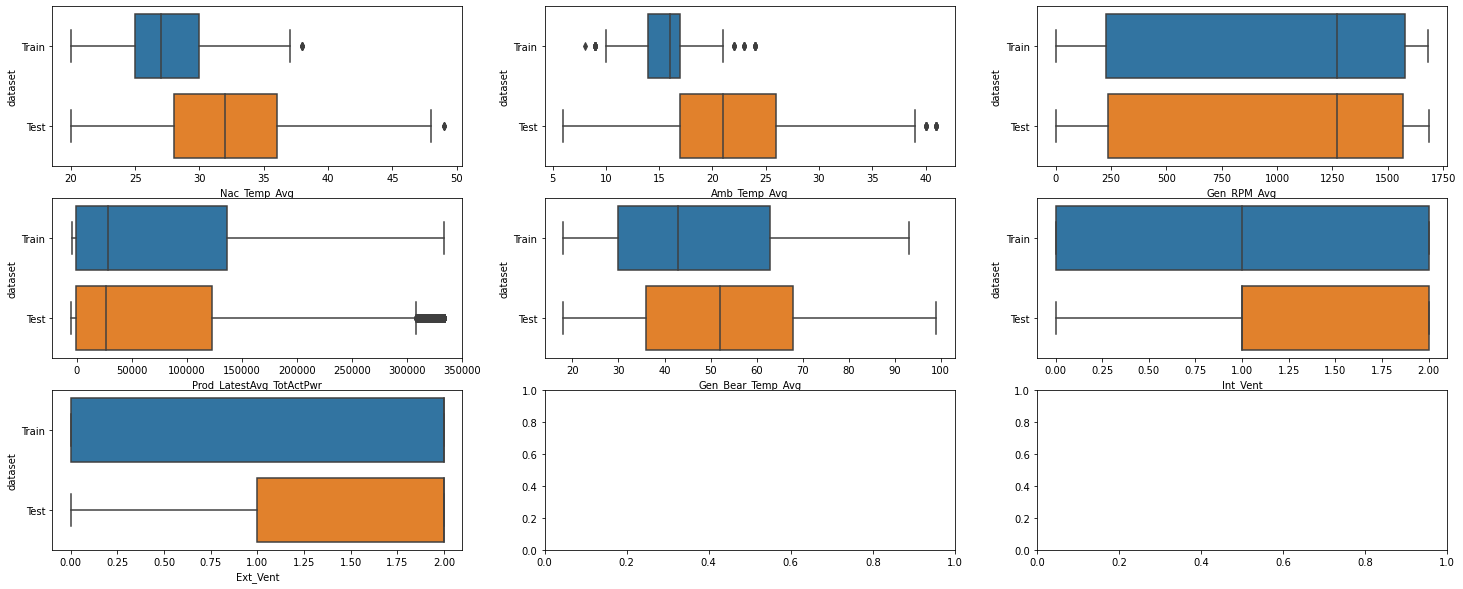

In [ ]:
%matplotlib inline
fig, axes = plt.subplots((len(features)//3) + 1, 3, figsize=(25,10))
for (i, feature) in zip(range(len(features)), features):
  sns.boxplot(data = data, x=feature, y='dataset', ax=axes[i//3][i%3])
  #axes[i//3][i%3].set_title(feature);

In [ ]:
#====================================================================================================================================================

**Baseline using Linear Regression**

In [ ]:
y_column = 'Gen_Bear_Temp_Avg'

In [ ]:
# features = ['Amb_WindSpeed_Avg', 'Cont_Top_Temp_Avg', 'Cont_VCP_ChokcoilTemp_Avg', 'Cont_VCP_Temp_Avg', 'Cont_VCP_WtrTemp_Avg', 'Gear_Bear_Temp_Avg', 
#             'Gear_Oil_Temp_Avg',  'Gen_RPM_Avg', 'Grd_Prod_Pwr_Avg', 
#             'HVTrafo_Phase2_Temp_Avg', 'HVTrafo_Phase3_Temp_Avg', 'Rtr_RPM_Avg', 'Nac_Temp_Avg', 'Amb_Temp_Avg', 'Gen_Bear_Temp_Avg', ]

In [ ]:
# #features = ['Grd_Prod_VoltPhse1_Avg', 'Grd_Prod_VoltPhse3_Avg', 'Grd_Prod_CurPhse1_Avg', 'Grd_Prod_CurPhse3_Avg', 'Grd_Prod_CurPhse1_Avg', 'Gen_RPM_Avg', 
#             'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 'Gear_Oil_Temp_Avg', 'Gear_Bear_Temp_Avg', 'Amb_Temp_Avg', 'Cont_Hub_Temp_Avg', 
#             'Nac_Temp_Avg', 'Cont_Top_Temp_Avg', 'Gen_Bear_Temp_Avg', ]

In [ ]:
T09_data_logs[train_start : train_end][['Int_Vent']].corrwith(T09_data_logs[train_start : train_end]['Gen_Bear_Temp_Avg'])

Int_Vent    0.810796
dtype: float64

**Batch 1: Generator Bearings 1** Train Jan-May, Test Jun-Nov

In [ ]:
features = ['Nac_Temp_Avg', 'Amb_Temp_Avg', 'Gen_RPM_Avg', 'Prod_LatestAvg_TotActPwr', 'Gen_Bear_Temp_Avg',
             'Int_Vent', 'Ext_Vent']

dataset_1, X_train_1, Y_train_1, predictions_train_1, errors_train_1, X_test_1, Y_test_1, predictions_test_1, errors_test_1, model_1, = \
                        implement_pipeline_reg(T09_data_logs, train_date_start = train_start, train_date_end = train_end,
                                           test_date_start = test_start, test_date_end = test_end, y_column = y_column, turbine_id='T09',
                         features=features);

Training model...
Evaluating model...
RMSE Train:  8.113714722892556
RMSE Test:  8.116343394306185


In [ ]:
features = ['Nac_Temp_Avg', 'Amb_Temp_Avg', 'Gen_RPM_Avg', 'Prod_LatestAvg_TotActPwr', 'Gen_Bear_Temp_Avg', ]

dataset_x, X_train_x, Y_train_x, predictions_train_x, errors_train_x, X_test_x, Y_test_x, predictions_test_x, errors_test_x, model_x, = \
                        implement_pipeline_reg(T09_data_logs, train_date_start = train_start, train_date_end = train_end,
                                           test_date_start = test_start, test_date_end = test_end, y_column = y_column, turbine_id='T09',
                         features=features);

Training model...
Evaluating model...
RMSE Train:  8.255278334104775
RMSE Test:  8.4456118917009


In [ ]:
agg_train_errors = errors_train_1.rolling('10T').mean()
agg_train_errors['dataset'] = 'Train'

agg_test_errors = errors_test_1.rolling('10T').mean()
agg_test_errors['dataset'] = 'Test'

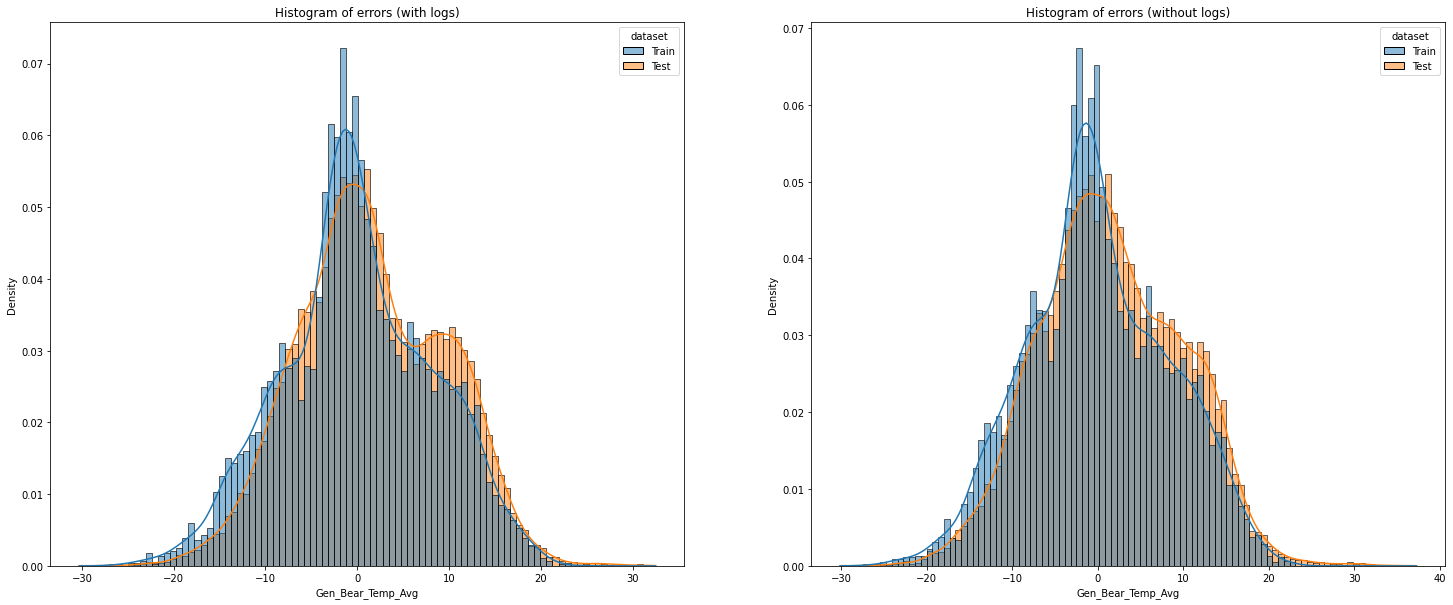

In [ ]:
#Distribution of errors
fig, axes = plt.subplots(1, 2, figsize=(25,10))
#fig = plt.figure(figsize=(15,10))
errors_train_1['dataset'] = 'Train'
errors_test_1['dataset'] = 'Test'

errors_train_x['dataset'] = 'Train'
errors_test_x['dataset'] = 'Test'

sns.histplot(pd.concat([errors_train_1, errors_test_1], ignore_index=True), x=y_column, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[0])
sns.histplot(pd.concat([errors_train_x, errors_test_x], ignore_index=True), x=y_column, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[1])
axes[0].set_title('Histogram of errors (with logs)');
axes[1].set_title('Histogram of errors (without logs)');

In [ ]:
#anomaly_threshold = errors_test_1[y_column].mean() + 3 * errors_test_1[y_column].std()
anomaly_threshold_1 = errors_train_1[y_column].mean() + 3 * errors_train_1[y_column].std()

Y_test_1['Anomaly'] = errors_test_1[y_column] > anomaly_threshold_1
Y_train_1['Anomaly'] = errors_train_1[y_column] > anomaly_threshold_1

anomaly_threshold_x = errors_train_x[y_column].mean() + 3 * errors_train_x[y_column].std()

Y_test_x['Anomaly'] = errors_test_x[y_column] > anomaly_threshold_x
Y_train_x['Anomaly'] = errors_train_x[y_column] > anomaly_threshold_x

In [ ]:
print(anomaly_threshold_1)
anomaly_threshold_x

24.342981721556033


24.767704615799964

In [ ]:
#Alarms
Y_test_1[Y_test_1['Anomaly']]

Gen_Bear_Temp_Avg  Anomaly
Timestamp                                            
2016-02-17 15:20:00+00:00               56.0     True
2016-03-07 18:40:00+00:00               81.0     True
2016-03-08 12:00:00+00:00               54.0     True
2016-03-22 02:00:00+00:00               58.0     True
2016-03-22 17:10:00+00:00               70.0     True
2016-05-01 15:20:00+00:00               84.0     True
2016-05-03 11:30:00+00:00               86.0     True
2016-05-03 11:40:00+00:00               81.0     True
2016-05-05 13:20:00+00:00               80.0     True
2016-05-05 13:30:00+00:00               74.0     True
2016-06-07 17:10:00+00:00               96.0     True
2016-06-07 17:20:00+00:00               91.0     True
2016-06-21 16:30:00+00:00               97.0     True
2016-06-21 18:10:00+00:00               96.0     True
2016-06-22 15:10:00+00:00               97.0     True
2016-06-22 15:20:00+00:00               92.0     True
2016-07-03 13:20:00+00:00               84.0     True
2016-07-03 17:20:00+00:00               97.0     True
2016-07-03 17:30:00+00:00               92.0     True
2016-07-03 20:30:00+00:00               97.0     True
2016-07-03 20:40:00+00:00               92.0     True
2016-07-09 17:20:00+00:00               97.0     True
2016-07-10 05:50:00+00:00               94.0     True
2016-07-14 12:50:00+00:00               97.0     True
2016-07-14 17:30:00+00:00               96.0     True
2016-07-14 17:40:00+00:00               91.0     True
2016-07-15 15:20:00+00:00               94.0     True
2016-07-24 11:40:00+00:00               93.0     True
2016-07-24 11:50:00+00:00               88.0     True
2016-07-24 16:20:00+00:00               95.0     True
2016-07-25 14:30:00+00:00               95.0     True
2016-08-06 12:50:00+00:00               93.0     True
2016-08-06 19:40:00+00:00               96.0     True
2016-08-06 19:50:00+00:00               92.0     True
2016-08-07 14:10:00+00:00               92.0     True
2016-08-07 14:20:00+00:00               87.0     True
2016-08-07 20:20:00+00:00               95.0     True
2016-08-08 15:50:00+00:00               95.0     True
2016-08-10 15:00:00+00:00               98.0     True
2016-08-10 15:10:00+00:00               93.0     True
2016-08-12 15:00:00+00:00               94.0     True
2016-08-12 20:10:00+00:00               95.0     True
2016-08-22 14:30:00+00:00               95.0     True
2016-08-22 18:40:00+00:00               94.0     True
2016-08-23 13:30:00+00:00               93.0     True
2016-08-23 17:10:00+00:00               94.0     True
2016-09-01 14:10:00+00:00               98.0     True
2016-09-01 14:20:00+00:00               92.0     True
2016-09-27 17:20:00+00:00               91.0     True
2016-09-27 18:10:00+00:00               83.0     True
2016-09-28 15:20:00+00:00               94.0     True
2016-09-29 13:40:00+00:00               97.0     True
2016-09-29 19:10:00+00:00               97.0     True
2016-09-29 19:20:00+00:00               92.0     True

In [ ]:
relevant_logs = log_data_T09[log_data_T09.Remark.str.contains('bearing 1', na=False, case=False)]
Y_test_1['logs_found'] = None
for index, row in Y_test_1[Y_test_1.Anomaly].iterrows():
  filtered_logs = relevant_logs[(index - pd.Timedelta('24H')) : index]
  if not filtered_logs.empty:
    string = ''
    for i, r in filtered_logs.iterrows():
      string = string + r.Remark + ' @ ' + str(i) + '\n '
    Y_test_1.loc[index, 'logs_found'] = string

  else:
    Y_test_1.loc[index, 'logs_found'] = 'No logs found'

Y_test_x['logs_found'] = None
for index, row in Y_test_x[Y_test_x.Anomaly].iterrows():
  filtered_logs = relevant_logs[(index - pd.Timedelta('24H')) : index]
  if not filtered_logs.empty:
    string = ''
    for i, r in filtered_logs.iterrows():
      string = string + r.Remark + ' @ ' + str(i) + '\n '
    Y_test_x.loc[index, 'logs_found'] = string

  else:
    Y_test_x.loc[index, 'logs_found'] = 'No logs found'

In [ ]:
Y_test_1.loc['2016-10-17 09:10:00+00', 'Anomaly'] = True
Y_test_1.loc['2016-10-17 09:10:00+00', 'logs_found'] = 'Generator bearings replaced'

Y_test_x.loc['2016-10-17 09:10:00+00', 'Anomaly'] = True
Y_test_x.loc['2016-10-17 09:10:00+00', 'logs_found'] = 'Generator bearings replaced'

In [ ]:
Y_test_1['date'] = pd.to_datetime(Y_test_1.index.date)
Y_test_x['date'] = pd.to_datetime(Y_test_x.index.date)

# gt = pd.concat([Y_test_1['2016-02-17 18:00' : '2016-02-17 20:00'], Y_test_1['2016-08-22 10:00' : '2016-08-22 20:00'], 
#                 Y_test_1['2016-09-01 13:00' : '2016-09-01 15:00'], Y_test_1['2016-10-06 02:00' : '2016-10-06 04:00'], 
#                 Y_test_1['2016-10-17 08:00' : '2016-10-17 10:00']])
# pr = pd.concat([predictions_test_1['2016-02-26 18:00' : '2016-02-26 20:00'], predictions_test_1['2016-08-22 10:00' : '2016-08-22 20:00'], 
#                 predictions_test_1['2016-09-01 13:00' : '2016-09-01 15:00'], predictions_test_1['2016-10-06 02:00' : '2016-10-06 04:00'], 
#                 predictions_test_1['2016-10-17 08:00' : '2016-10-17 10:00']])
# x = pd.concat([X_test_1['2016-02-26 18:00' : '2016-02-26 20:00'], X_test_1['2016-08-22 10:00' : '2016-08-22 20:00'], 
#                 X_test_1['2016-09-01 13:00' : '2016-09-01 15:00'], X_test_1['2016-10-06 02:00' : '2016-10-06 04:00'], 
#                 X_test_1['2016-10-17 08:00' : '2016-10-17 10:00']])

# gt = pd.concat([Y_test_1['2016-02-17'], Y_test_1['2016-08-22'], 
#                 Y_test_1['2016-09-01'], Y_test_1['2016-10-06'], 
#                 Y_test_1['2016-10-17']])
# pr = pd.concat([predictions_test_1['2016-02-17'], predictions_test_1['2016-08-22'], 
#                 predictions_test_1['2016-09-01'], predictions_test_1['2016-10-06'], 
#                 predictions_test_1['2016-10-17']])
# x = pd.concat([X_test_1['2016-02-17'], X_test_1['2016-08-22'], 
#                 X_test_1['2016-09-01'], X_test_1['2016-10-06'], 
#                 X_test_1['2016-10-17']])

# gt = Y_test_1
# pr = Y_test_1

gt_1 = Y_test_1[Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly']].index.date))]
pr_1 = predictions_test_1[Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly']].index.date))]
x_1 = X_test_1[Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly']].index.date))]

gt_1.reset_index(inplace=True)
pr_1.reset_index(inplace=True)
x_1.reset_index(inplace=True)

gt_1.loc[gt_1['Timestamp'].diff().dt.total_seconds() > 600, y_column] = np.NAN
pr_1.loc[gt_1['Timestamp'].diff().dt.total_seconds() > 600, y_column] = np.NAN
x_1.loc[x_1['Timestamp'].diff().dt.total_seconds() > 600, 'Int_Vent'] = np.NAN

#=================================================================================

gt_x = Y_test_x[Y_test_x.date.isin(list(Y_test_x[Y_test_x['Anomaly']].index.date))]
pr_x = predictions_test_x[Y_test_x.date.isin(list(Y_test_x[Y_test_x['Anomaly']].index.date))]
x_x = X_test_1[Y_test_x.date.isin(list(Y_test_x[Y_test_x['Anomaly']].index.date))]

gt_x.reset_index(inplace=True)
pr_x.reset_index(inplace=True)
x_x.reset_index(inplace=True)

gt_x.loc[gt_x['Timestamp'].diff().dt.total_seconds() > 600, y_column] = np.NAN
pr_x.loc[gt_x['Timestamp'].diff().dt.total_seconds() > 600, y_column] = np.NAN
x_x.loc[x_x['Timestamp'].diff().dt.total_seconds() > 600, 'Int_Vent'] = np.NAN

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


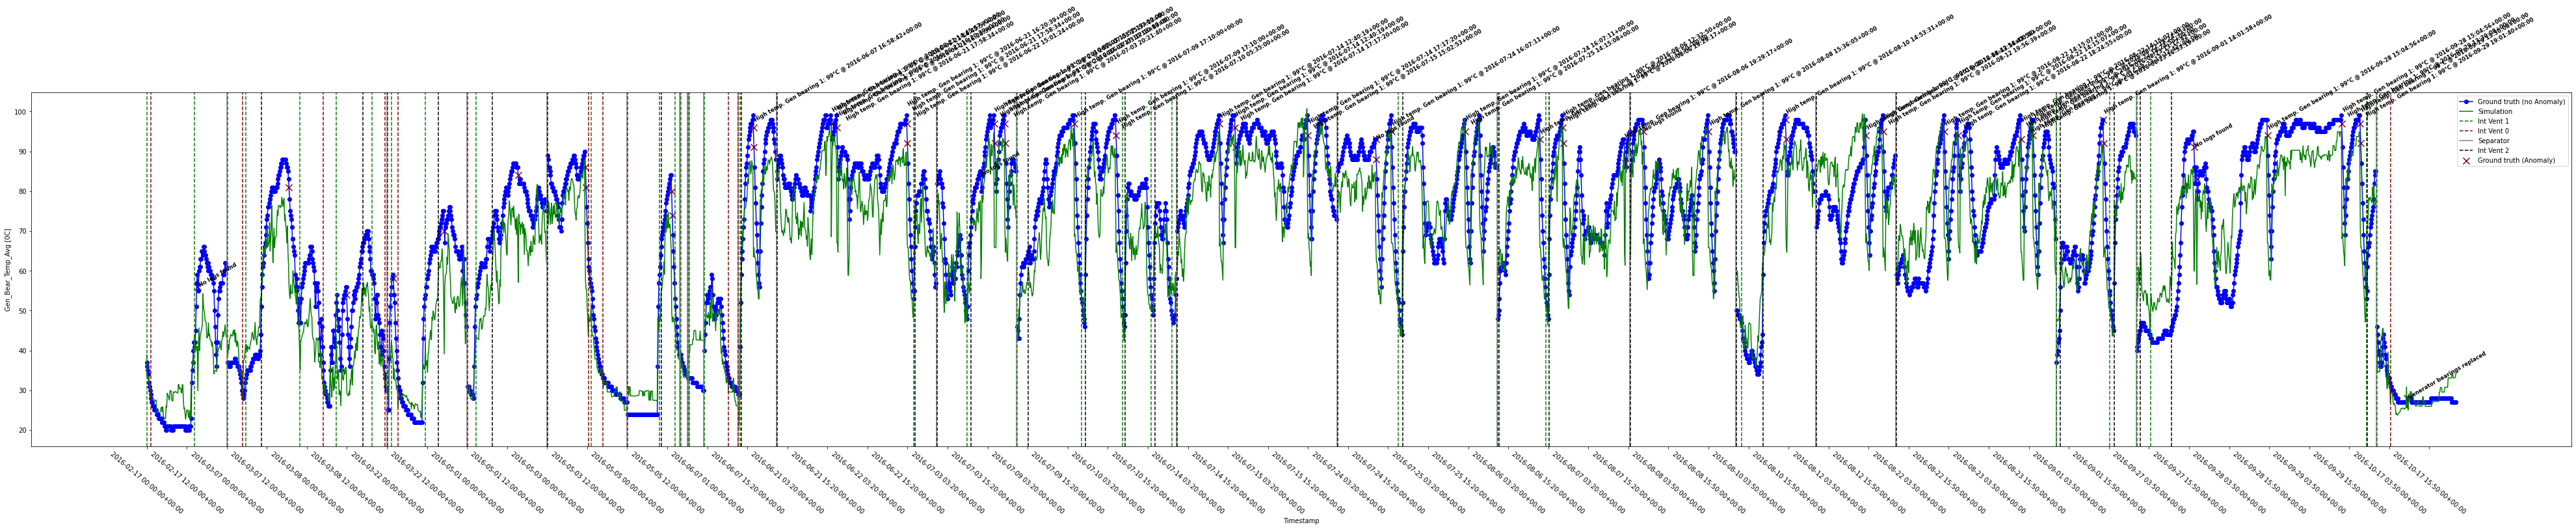

In [ ]:
#%matplotlib widget
#plt.figure(figsize=(25,15))
#sns.scatterplot(x='Timestamp', y='Gen_Bear_Temp_Avg', hue='Anomaly', data=Y_test_1['2016-08-22' : '2016-08-22'].reset_index())
plot_predicted_vs_true(pr_1, gt_1, y_column, hue='Anomaly', figsize=(70,10))

last_value = -1
for ix, row in x_1.iterrows():
  if str(row.Int_Vent) == 'nan':
    plt.axvline(x=ix, linestyle='-', color='grey', label='Separator')
    last_value = -1
  if row.Int_Vent != last_value:
    if row.Int_Vent == 0.0:
      plt.axvline(x=ix, linestyle='--', color='darkred', label='Int Vent 0')
    elif row.Int_Vent == 1:
      plt.axvline(x=ix, linestyle='--', color='green', label='Int Vent 1')
    elif row.Int_Vent == 2:
      plt.axvline(x=ix, linestyle='--', color='black', label='Int Vent 2')
    
    last_value=row.Int_Vent

last_logs_found = ''
for line in range(0, gt_1.shape[0], 1):
  if gt_1.Anomaly[line] and gt_1.logs_found[line] != last_logs_found:
    plt.text(gt_1.index[line], gt_1.Gen_Bear_Temp_Avg[line], gt_1.logs_found[line], size='small', color='black', weight='semibold', rotation=30)
    #plt.axvline(x=gt.index[line], linestyle='--', color='black')
    last_logs_found = gt_1.logs_found[line]

  elif gt_1.logs_found[line] == 'Generator bearings replaced':
      plt.text(gt_1.index[line], gt_1.Gen_Bear_Temp_Avg[line], '!GENERATOR BEARINGS REPLACED!', size='medium', color='darkred', weight='bold', rotation=30)
      #plt.axvline(x=gt.index[line], linestyle='--', color='darkred')
plt.xticks(range(0, gt_1.shape[0], 72), labels = gt_1['Timestamp'][:-1:72], rotation=320);
plt.grid(False);

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());

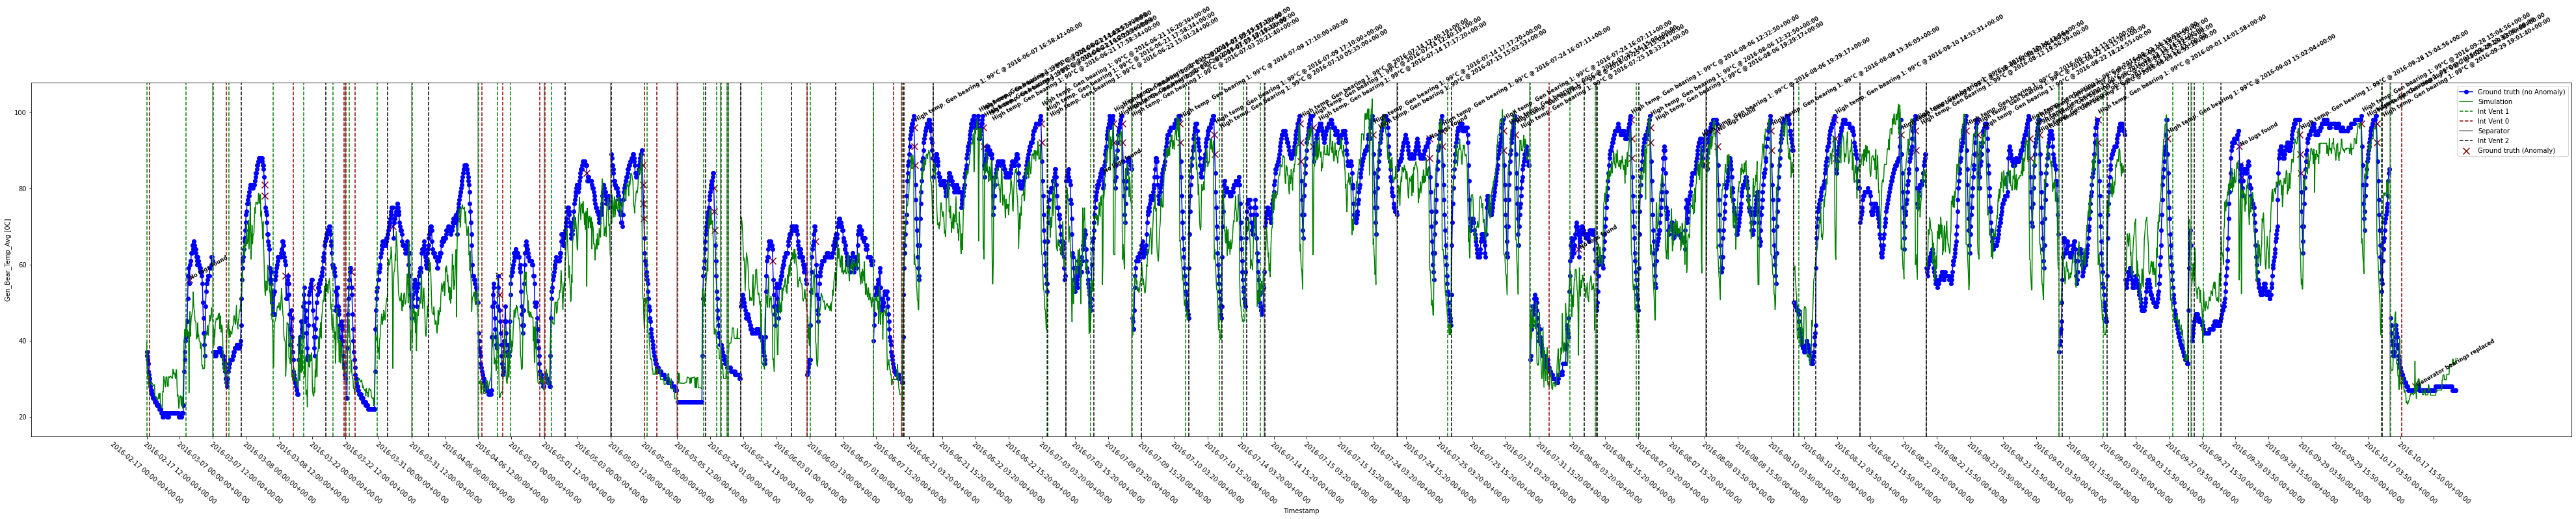

In [ ]:
#plt.figure(figsize=(25,15))
#sns.scatterplot(x='Timestamp', y='Gen_Bear_Temp_Avg', hue='Anomaly', data=Y_test_x['2016-08-22' : '2016-08-22'].reset_index())
plot_predicted_vs_true(pr_x, gt_x, y_column, hue='Anomaly', figsize=(70,10))

last_value = -1
for ix, row in x_x.iterrows():
  if str(row.Int_Vent) == 'nan':
    plt.axvline(x=ix, linestyle='-', color='grey', label='Separator')
    last_value = -1
  if row.Int_Vent != last_value:
    if row.Int_Vent == 0.0:
      plt.axvline(x=ix, linestyle='--', color='darkred', label='Int Vent 0')
    elif row.Int_Vent == 1:
      plt.axvline(x=ix, linestyle='--', color='green', label='Int Vent 1')
    elif row.Int_Vent == 2:
      plt.axvline(x=ix, linestyle='--', color='black', label='Int Vent 2')
    
    last_value=row.Int_Vent

last_logs_found = ''
for line in range(0, gt_x.shape[0], 1):
  if gt_x.Anomaly[line] and gt_x.logs_found[line] != last_logs_found:
    plt.text(gt_x.index[line], gt_x.Gen_Bear_Temp_Avg[line], gt_x.logs_found[line], size='small', color='black', weight='semibold', rotation=30)
    #plt.axvline(x=gt.index[line], linestyle='--', color='black')
    last_logs_found = gt_x.logs_found[line]

  elif gt_x.logs_found[line] == 'Generator bearings replaced':
      plt.text(gt_x.index[line], gt_x.Gen_Bear_Temp_Avg[line], '!GENERATOR BEARINGS REPLACED!', size='medium', color='darkred', weight='bold', rotation=30)
      #plt.axvline(x=gt.index[line], linestyle='--', color='darkred')
plt.xticks(range(0, gt_x.shape[0], 72), labels = gt_x['Timestamp'][:-1:72], rotation=320);
plt.grid(False);

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());

In [ ]:
Y_test_1[Y_test_1['Anomaly']].index

DatetimeIndex(['2016-02-17 15:20:00+00:00', '2016-03-07 18:40:00+00:00',
               '2016-03-08 12:00:00+00:00', '2016-03-22 02:00:00+00:00',
               '2016-03-22 17:10:00+00:00', '2016-05-01 15:20:00+00:00',
               '2016-05-03 11:30:00+00:00', '2016-05-03 11:40:00+00:00',
               '2016-05-05 13:20:00+00:00', '2016-05-05 13:30:00+00:00',
               '2016-06-07 17:10:00+00:00', '2016-06-07 17:20:00+00:00',
               '2016-06-21 16:30:00+00:00', '2016-06-21 18:10:00+00:00',
               '2016-06-22 15:10:00+00:00', '2016-06-22 15:20:00+00:00',
               '2016-07-03 13:20:00+00:00', '2016-07-03 17:20:00+00:00',
               '2016-07-03 17:30:00+00:00', '2016-07-03 20:30:00+00:00',
               '2016-07-03 20:40:00+00:00', '2016-07-09 17:20:00+00:00',
               '2016-07-10 05:50:00+00:00', '2016-07-14 12:50:00+00:00',
               '2016-07-14 17:30:00+00:00', '2016-07-14 17:40:00+00:00',
               '2016-07-15 15:20:00+00:00', '2016-0

In [ ]:
Y_test_x[Y_test_x['Anomaly']].index

DatetimeIndex(['2016-02-17 15:20:00+00:00', '2016-03-07 18:40:00+00:00',
               '2016-03-07 18:50:00+00:00', '2016-03-08 02:20:00+00:00',
               '2016-03-08 12:00:00+00:00', '2016-03-22 02:00:00+00:00',
               '2016-03-22 17:10:00+00:00', '2016-03-31 16:10:00+00:00',
               '2016-04-06 07:30:00+00:00', '2016-04-06 07:40:00+00:00',
               '2016-05-01 15:20:00+00:00', '2016-05-03 11:30:00+00:00',
               '2016-05-03 11:40:00+00:00', '2016-05-03 11:50:00+00:00',
               '2016-05-03 12:00:00+00:00', '2016-05-05 13:20:00+00:00',
               '2016-05-05 13:30:00+00:00', '2016-05-05 13:40:00+00:00',
               '2016-05-24 11:40:00+00:00', '2016-06-03 03:10:00+00:00',
               '2016-06-07 17:10:00+00:00', '2016-06-07 17:20:00+00:00',
               '2016-06-07 17:30:00+00:00', '2016-06-21 16:30:00+00:00',
               '2016-06-21 18:10:00+00:00', '2016-06-21 18:20:00+00:00',
               '2016-06-21 21:30:00+00:00', '2016-0

In [ ]:
Y_test_x[Y_test_x['Anomaly']][(Y_test_x[Y_test_x['Anomaly']].date - Y_test_1[Y_test_1['Anomaly']].date) > pd.Timedelta('0D')]

In [ ]:
Y_test_x[(Y_test_x.date.isin(list(Y_test_x[Y_test_x['Anomaly']].index.date))) & ~ (Y_test_x.date.isin(list(Y_test_1[Y_test_1['Anomaly']].index.date))) ].date.unique()

array(['2016-03-31T00:00:00.000000000', '2016-04-06T00:00:00.000000000',
       '2016-05-24T00:00:00.000000000', '2016-06-03T00:00:00.000000000',
       '2016-07-31T00:00:00.000000000', '2016-09-03T00:00:00.000000000'],
      dtype='datetime64[ns]')

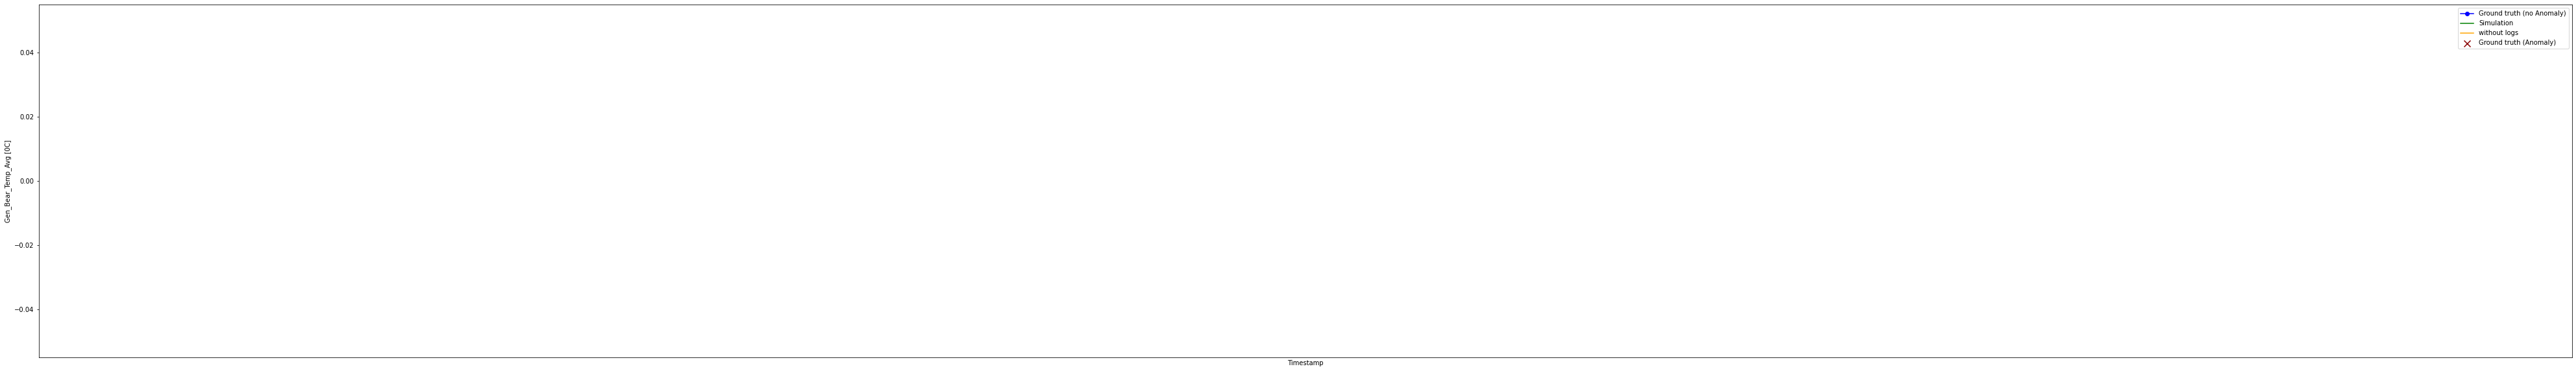

In [ ]:
ixes = (Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly']].index.date))) & ~(Y_test_1.date.isin(list(Y_test_x[Y_test_x['Anomaly']].index.date)))
gt_1_ex = Y_test_1[ixes].reset_index()
pr_1_ex = predictions_test_1[ixes].reset_index()
x_1_ex = X_test_1[ixes].reset_index()

pr_x_ex = predictions_test_x[ixes].reset_index()

plot_predicted_vs_true(pr_1_ex, gt_1_ex, y_column, hue='Anomaly', figsize=(70,10))
plt.plot(pr_x_ex.index, pr_x_ex[y_column], color='orange', label='without logs')

last_value = -1
for ix, row in x_1_ex.iterrows():
  if str(row.Int_Vent) == 'nan':
    plt.axvline(x=ix, linestyle='-', color='grey', label='Separator')
    last_value = -1
  if row.Int_Vent != last_value:
    if row.Int_Vent == 0.0:
      plt.axvline(x=ix, linestyle='--', color='darkred', label='Int Vent 0')
    elif row.Int_Vent == 1:
      plt.axvline(x=ix, linestyle='--', color='green', label='Int Vent 1')
    elif row.Int_Vent == 2:
      plt.axvline(x=ix, linestyle='--', color='black', label='Int Vent 2')
    
    last_value=row.Int_Vent

last_logs_found = ''
for line in range(0, gt_1_ex.shape[0], 1):
  if gt_1_ex.Anomaly[line] and gt_1_ex.logs_found[line] != last_logs_found:
    plt.text(gt_1_ex.index[line], gt_1_ex.Gen_Bear_Temp_Avg[line], gt_1_ex.logs_found[line], size='small', color='black', weight='semibold', rotation=30)
    #plt.axvline(x=gt.index[line], linestyle='--', color='black')
    last_logs_found = gt_1_ex.logs_found[line]

  elif gt_1_ex.logs_found[line] == 'Generator bearings replaced':
      plt.text(gt_1_ex.index[line], gt_1_ex.Gen_Bear_Temp_Avg[line], '!GENERATOR BEARINGS REPLACED!', size='medium', color='darkred', weight='bold', rotation=30)
      #plt.axvline(x=gt.index[line], linestyle='--', color='darkred')
plt.xticks(range(0, gt_1_ex.shape[0], 72), labels = gt_1_ex['Timestamp'][:-1:72], rotation=320);
plt.grid(False);

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());

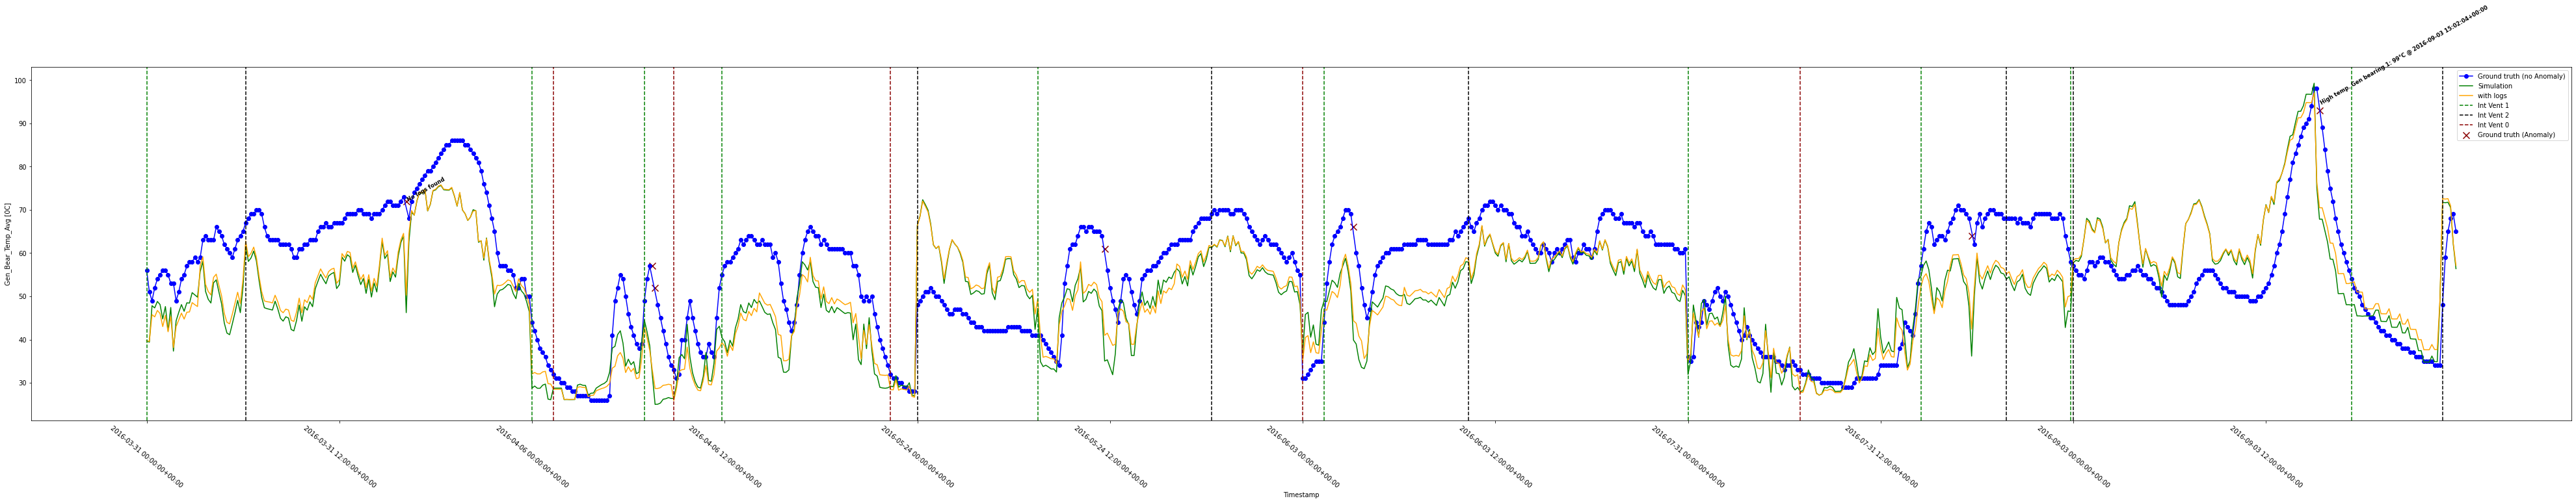

In [ ]:
ixes = (Y_test_x.date.isin(list(Y_test_x[Y_test_x['Anomaly']].index.date))) & ~(Y_test_x.date.isin(list(Y_test_1[Y_test_1['Anomaly']].index.date)))

gt_x_ex = Y_test_x[ixes].reset_index()
pr_x_ex = predictions_test_x[ixes].reset_index()
x_x_ex = X_test_1[ixes].reset_index()

pr_1_ex = predictions_test_1[ixes].reset_index()

plot_predicted_vs_true(pr_x_ex, gt_x_ex, y_column, hue='Anomaly', figsize=(70,10))
plt.plot(pr_1_ex.index, pr_1_ex[y_column], color='orange', label='with logs')

last_value = -1
for ix, row in x_x_ex.iterrows():
  if str(row.Int_Vent) == 'nan':
    plt.axvline(x=ix, linestyle='-', color='grey', label='Separator')
    last_value = -1
  if row.Int_Vent != last_value:
    if row.Int_Vent == 0.0:
      plt.axvline(x=ix, linestyle='--', color='darkred', label='Int Vent 0')
    elif row.Int_Vent == 1:
      plt.axvline(x=ix, linestyle='--', color='green', label='Int Vent 1')
    elif row.Int_Vent == 2:
      plt.axvline(x=ix, linestyle='--', color='black', label='Int Vent 2')
    
    last_value=row.Int_Vent

last_logs_found = ''
for line in range(0, gt_x_ex.shape[0], 1):
  if gt_x_ex.Anomaly[line] and gt_x_ex.logs_found[line] != last_logs_found:
    plt.text(gt_x_ex.index[line], gt_x_ex.Gen_Bear_Temp_Avg[line], gt_x_ex.logs_found[line], size='small', color='black', weight='semibold', rotation=30)
    #plt.axvline(x=gt.index[line], linestyle='--', color='black')
    last_logs_found = gt_x_ex.logs_found[line]

  elif gt_x_ex.logs_found[line] == 'Generator bearings replaced':
      plt.text(gt_x_ex.index[line], gt_x_ex.Gen_Bear_Temp_Avg[line], '!GENERATOR BEARINGS REPLACED!', size='medium', color='darkred', weight='bold', rotation=30)
      #plt.axvline(x=gt.index[line], linestyle='--', color='darkred')
plt.xticks(range(0, gt_x_ex.shape[0], 72), labels = gt_x_ex['Timestamp'][:-1:72], rotation=320);
plt.grid(False);

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());

In [ ]:
X_train_neg_err = X_train_1[(errors_train_1['Gen_Bear_Temp_Avg'] > -24) & (errors_train_1['Gen_Bear_Temp_Avg'] < 0)]
Y_train_neg_err = Y_train_1[(errors_train_1['Gen_Bear_Temp_Avg'] > -24) & (errors_train_1['Gen_Bear_Temp_Avg'] < -0)]

pred_train_neg_err = predictions_train_1[(errors_train_1['Gen_Bear_Temp_Avg'] > -24) & (errors_train_1['Gen_Bear_Temp_Avg'] < 0)]

In [ ]:
Y_train_neg_err = pd.merge_asof(Y_train_neg_err, log_data_T09['Remark'], left_index = True, right_index = True, tolerance = pd.Timedelta('10m'))

In [ ]:
plt.figure(figsize=(25,7))
ax = sns.lineplot(x='Timestamp', y='Gen_Bear_Temp_Avg', data=Y_train_neg_err, marker='o')
ax = sns.lineplot(x='Timestamp', y='Gen_Bear_Temp_Avg', data=pred_train_neg_err, marker='o')
ax.set_title('Target');
ax.legend(['True', 'Predicted'])

In [ ]:
X_train_pos_err = X_train_1[(errors_train_1['Gen_Bear_Temp_Avg'] > 0) & (errors_train_1['Gen_Bear_Temp_Avg'] < 24)]
Y_train_pos_err = Y_train_1[(errors_train_1['Gen_Bear_Temp_Avg'] > 0) & (errors_train_1['Gen_Bear_Temp_Avg'] < 24)]

pred_train_pos_err = predictions_train_1[(errors_train_1['Gen_Bear_Temp_Avg'] > 0) & (errors_train_1['Gen_Bear_Temp_Avg'] < 24)]


In [ ]:
Y_train_pos_err = pd.merge_asof(Y_train_pos_err, log_data_T09['Remark'], left_index = True, right_index = True, tolerance = pd.Timedelta('10m'))

In [ ]:
plt.figure(figsize=(25,7))
ax = sns.lineplot(x='Timestamp', y='Gen_Bear_Temp_Avg', data=Y_train_pos_err, marker='o')
ax = sns.lineplot(x='Timestamp', y='Gen_Bear_Temp_Avg', data=pred_train_pos_err, marker='o')
ax.set_title('Target');
ax.legend(['True', 'Predicted'])

In [ ]:
X_train_zero_err = X_train_1[(errors_train_1['Gen_Bear_Temp_Avg'] > -1) & (errors_train_1['Gen_Bear_Temp_Avg'] < 1)]
Y_train_zero_err = Y_train_1[(errors_train_1['Gen_Bear_Temp_Avg'] > -1) & (errors_train_1['Gen_Bear_Temp_Avg'] < 1)]

pred_train_zero_err = predictions_train_1[(errors_train_1['Gen_Bear_Temp_Avg'] > -1) & (errors_train_1['Gen_Bear_Temp_Avg'] < 1)]

In [ ]:
Y_train_zero_err = pd.merge_asof(Y_train_zero_err, log_data_T09['Remark'], left_index = True, right_index = True, tolerance = pd.Timedelta('10m'))

In [ ]:
plt.figure(figsize=(25,7))
ax = sns.lineplot(x='Timestamp', y='Gen_Bear_Temp_Avg', data=Y_train_zero_err.rolling('1D').mean(), marker='o')
ax = sns.lineplot(x='Timestamp', y='Gen_Bear_Temp_Avg', data=pred_train_zero_err.rolling('1D').mean(), marker='o')
ax.set_title('Target');
ax.legend(['True', 'Predicted'])

In [ ]:
Y_train_pos_err['err'] = 'pos'
Y_train_neg_err['err'] = 'neg'
Y_train_zero_err['err'] = 'zero'
Y_train_err = pd.concat([Y_train_pos_err, Y_train_neg_err, Y_train_zero_err], ignore_index=True)

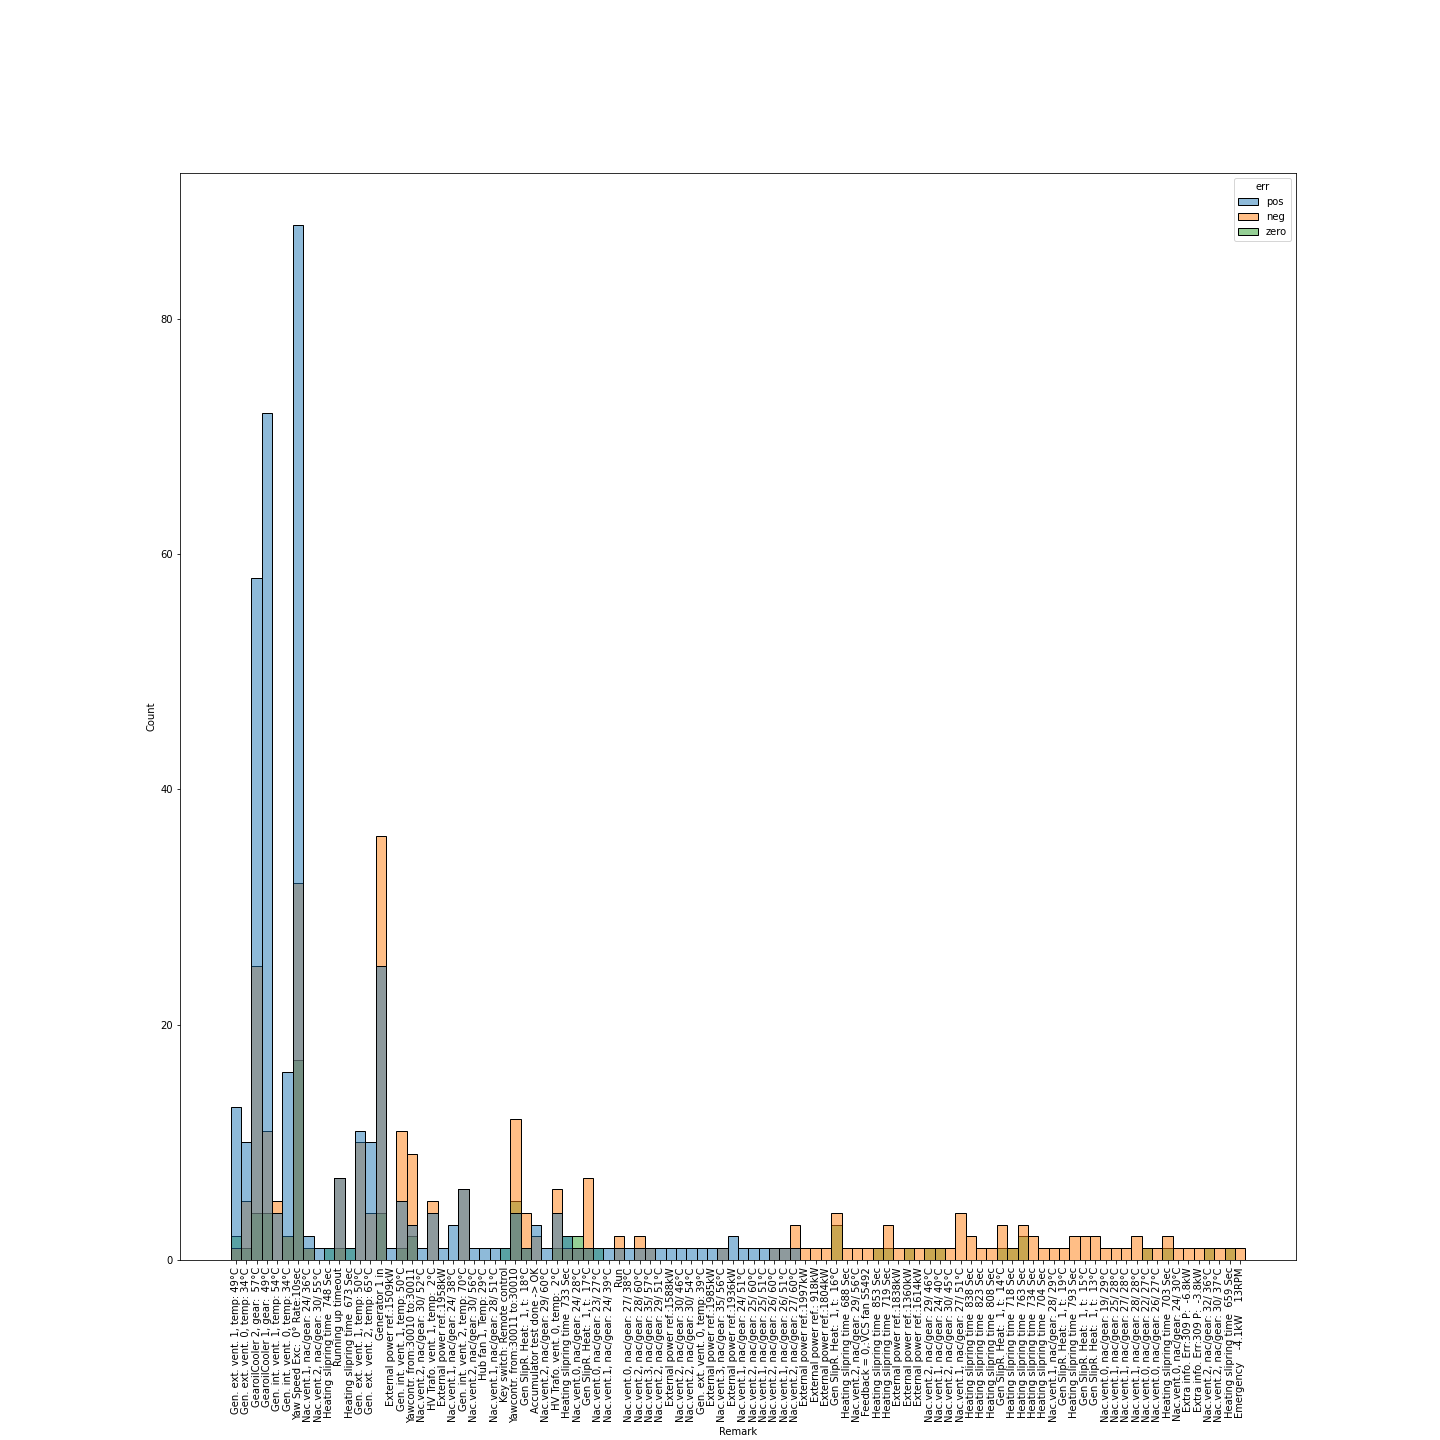

In [ ]:
plt.figure(figsize=(20,20))
sns.histplot(data=Y_train_err[Y_train_err['Remark'] != 'External power ref.:2000kW'], x='Remark', hue='err')
plt.xticks(rotation=90);

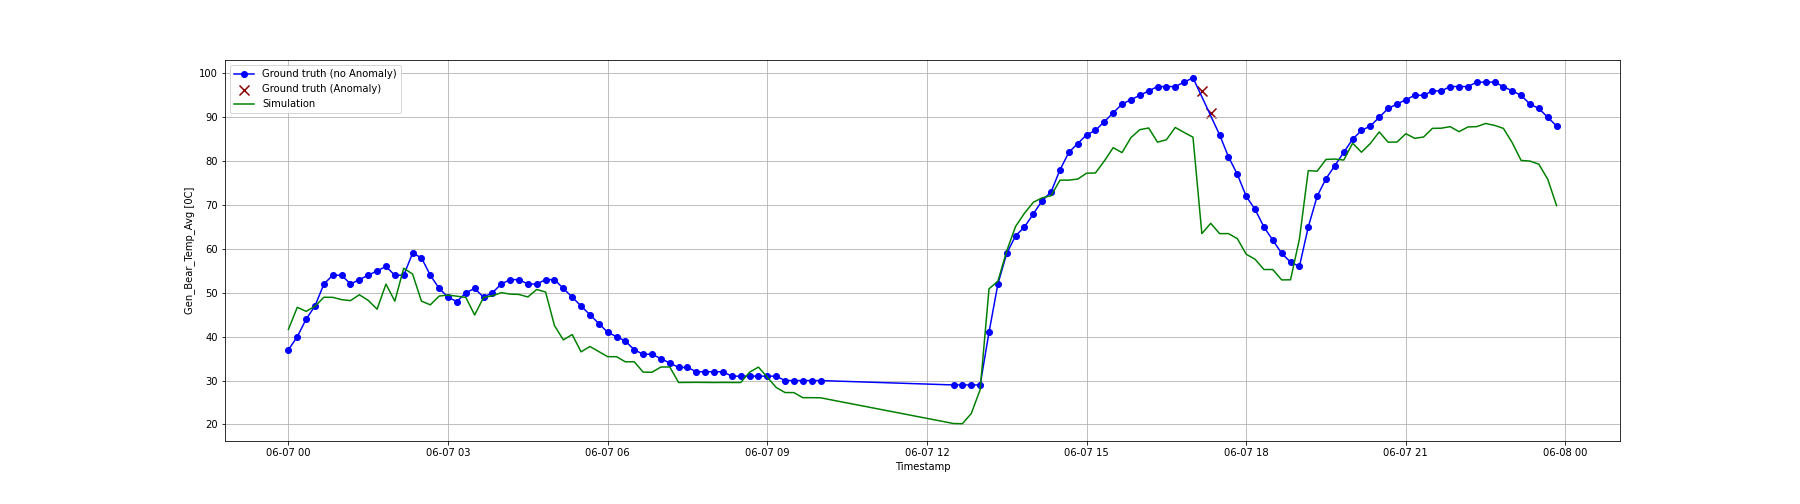

In [ ]:
#Failure 1: June 7, 2016 4:59 PM High temperature generator bearing
X_fail_1 = X_test_1.loc['2016-06-07':'2016-06-07']
Y_fail_1 = Y_test_1.loc['2016-06-07':'2016-06-07']
plot_predicted_vs_true(pd.DataFrame(model_1.predict(X_fail_1), columns=[y_column], index=X_fail_1.index),Y_fail_1, y_column, hue='Anomaly')
#plot_error(pd.DataFrame(model_1.predict(X_fail_1), columns=[y_column], index=X_fail_1.index),Y_fail_1, y_column)

<AxesSubplot:xlabel='Timestamp', ylabel='Gen_Bear_Temp_Avg'>

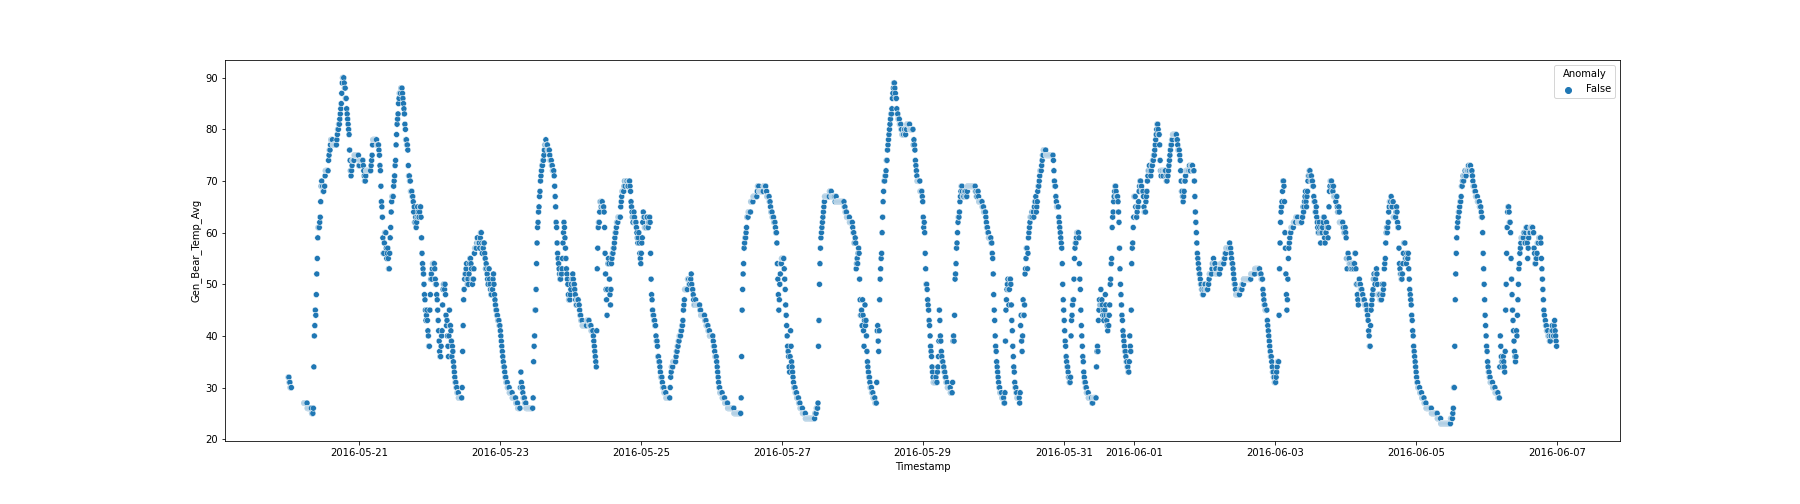

In [ ]:
#Before failure
fig = plt.figure(figsize=(25,7))
sns.scatterplot(x='Timestamp', y=y_column, hue='Anomaly', data=Y_test_1['2016-05-20':'2016-06-06'].reset_index())

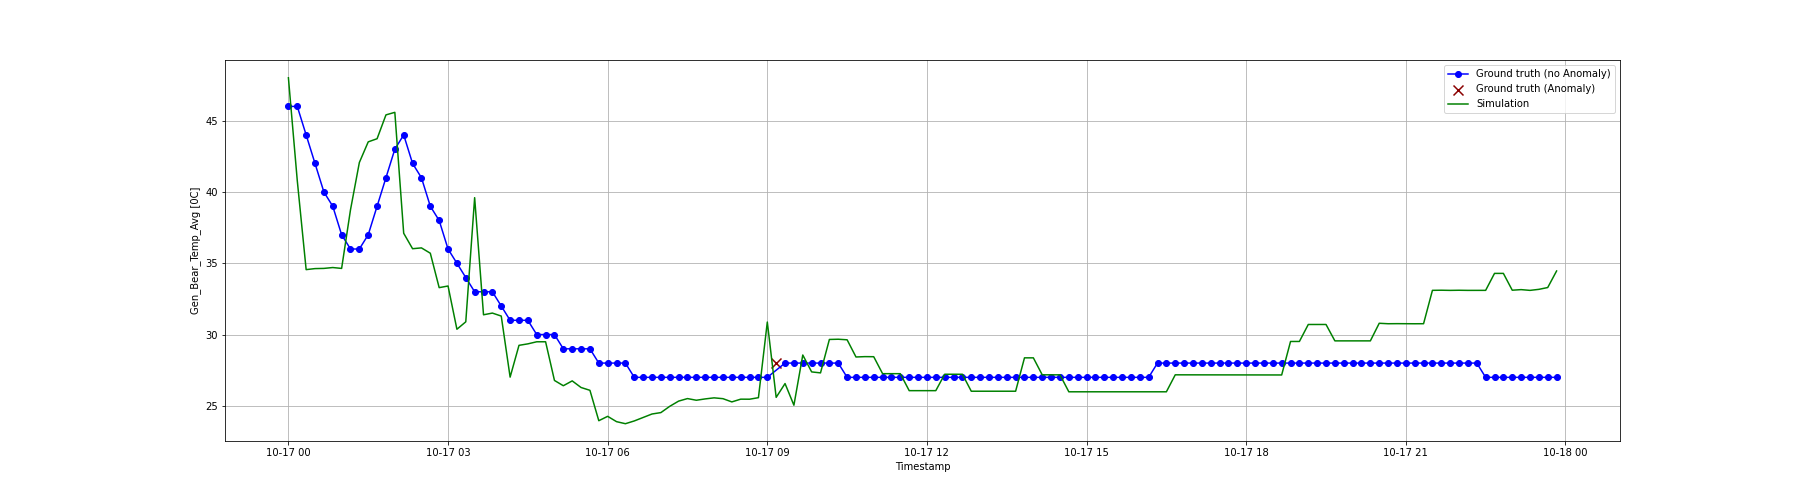

In [ ]:
#Failure 2: October 17, 2016 9:19 AM Generator bearings replaced
X_fail_2 = X_test_1.loc['2016-10-17':'2016-10-17']
Y_fail_2 = Y_test_1.loc['2016-10-17':'2016-10-17']
plot_predicted_vs_true(pd.DataFrame(model_1.predict(X_fail_2), columns=[y_column], index=X_fail_2.index),Y_fail_2, y_column, hue='Anomaly')
#plot_error(pd.DataFrame(model_1.predict(X_fail_2), columns=[y_column], index=X_fail_2.index),Y_fail_2, y_column)

<AxesSubplot:xlabel='Timestamp', ylabel='Gen_Bear_Temp_Avg'>

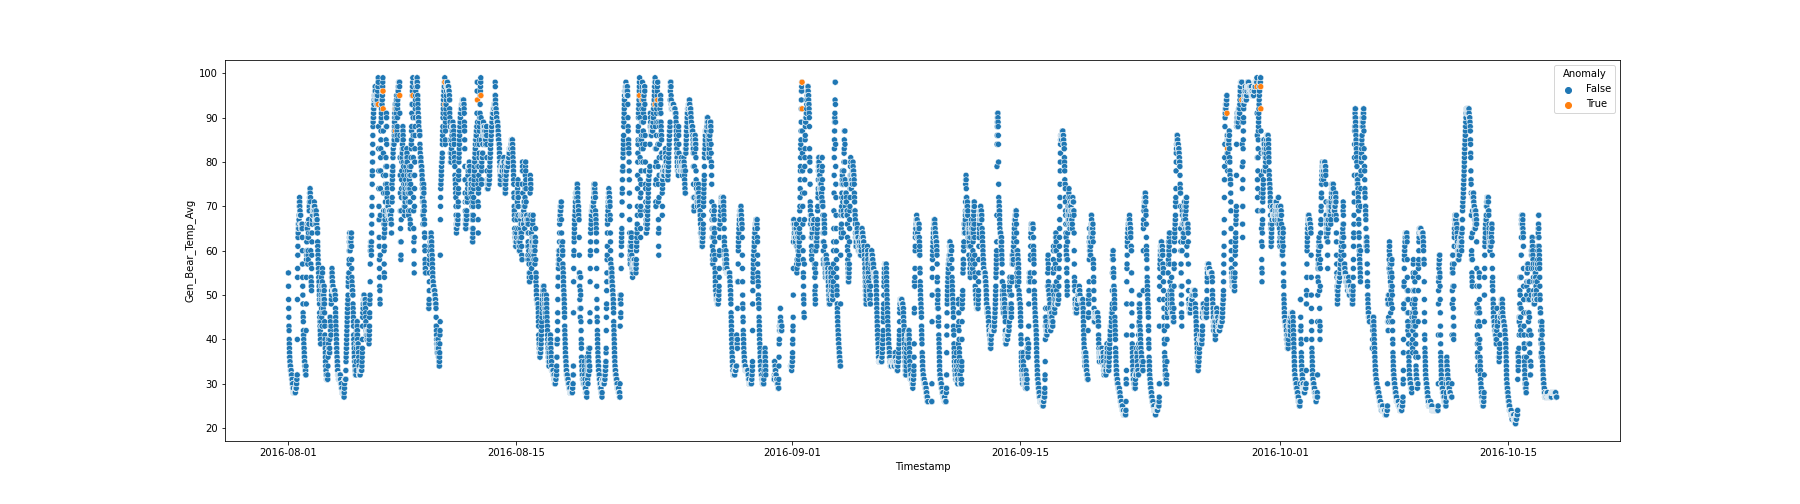

In [ ]:
#Before failure
fig = plt.figure(figsize=(25,7))
sns.scatterplot(x='Timestamp', y=y_column, hue='Anomaly', data=Y_test_1['2016-08-01':'2016-10-17'].reset_index())

**Compare error distributions of all turbines**

In [ ]:
combined_errors_train = errors_train_1
combined_errors_train['turbine_id'] = 'T09'

combined_errors_test = errors_test_1
combined_errors_test['turbine_id'] = 'T09'

combined_Y_test = pd.DataFrame()

In [ ]:
features = ['Nac_Temp_Avg', 'Amb_Temp_Avg', 'Gen_RPM_Avg', 'Grd_Prod_Pwr_Avg', 'Gen_Bear_Temp_Avg', 'Grd_Busbar_Temp_Avg', 
            ]

In [ ]:
for t_id in ['T01',]: #T01 is the only WTG no Generator Failures were reported for
  _, _, _, _, errors_train, _, Y_test, _, errors_test, _, = \
                        implement_pipeline_reg(all_data, train_date_start = train_start, train_date_end = train_end,
                                           test_date_start = test_start, test_date_end = test_end, y_column = y_column, turbine_id=t_id,
                         features=features);
  errors_train['turbine_id'] = t_id
  combined_errors_train = pd.concat([combined_errors_train, errors_train], ignore_index=True)

  errors_test['turbine_id'] = t_id
  combined_errors_test = pd.concat([combined_errors_test, errors_test], ignore_index=True)

  Y_test['turbine_id'] = t_id
  Y_test['Anomaly'] = errors_test[y_column] > anomaly_threshold
  #Y_test['Anomaly'] = errors_test[y_column] > 26
  combined_Y_test = pd.concat([combined_Y_test, Y_test.reset_index()], ignore_index=True)

In [ ]:
combined_errors_test[combined_errors_test['turbine_id'] == 'T01']['Gen_Bear_Temp_Avg'].max()

In [ ]:
fig = plt.figure(figsize=(15,10))
ax=sns.histplot(data=combined_errors_train, x=y_column, hue='turbine_id', kde=True, stat='density', common_norm=False)
ax.set_title('Histogram of train errors');

In [ ]:
fig = plt.figure(figsize=(15,10))
ax=sns.histplot(data=combined_errors_test, x=y_column, hue='turbine_id', kde=True, stat='density', common_norm=False)
ax.set_title('Histogram of test errors');

In [ ]:
#Anomalies?
print(combined_Y_test[combined_Y_test.Anomaly].shape[0])
sns.scatterplot(x='Timestamp', y='Gen_Bear_Temp_Avg', data=combined_Y_test[combined_Y_test.Anomaly], hue='turbine_id')

**Deep Learning**

**Batch 1:** Train Jan-May, Test Jun-Nov

In [ ]:
features = ['Nac_Temp_Avg', 'Amb_Temp_Avg', 'Gen_RPM_Avg', 'Prod_LatestAvg_TotActPwr', 'Gen_Bear_Temp_Avg',
             'Int_Vent', 'Ext_Vent']
dataset_2, X_train_2, Y_train_2, predictions_train_2, errors_train_2, X_test_2, Y_test_2, predictions_test_2, errors_test_2, model_2, scaler_input, scaler_target = \
                        implement_pipeline_mlp(T09_data_logs, train_date_start = train_start, train_date_end = train_end,
                                           test_date_start = test_start, test_date_end = test_end, y_column = y_column, turbine_id='T09',
                         features=features, epochs=300, normalize=True);

Training model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                70        
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
67/67 - 0s - loss: 0.1247 - 431ms/epoch - 6ms/step
Epoch 2/300
67/67 - 0s - loss: 0.0422 - 122ms/epoch - 2ms/step
Epoch 3/300
67/67 - 0s - loss: 0.0358 - 136ms/epoch - 2ms/step
Epoch 4/300
67/67 - 0s - loss: 0.0314 - 130ms/epoch - 2ms/step
Epoch 5/300
67/67 - 0s - loss: 0.0287 - 128ms/epoc

In [ ]:
features = ['Nac_Temp_Avg', 'Amb_Temp_Avg', 'Gen_RPM_Avg', 'Prod_LatestAvg_TotActPwr', 'Gen_Bear_Temp_Avg']
dataset_2_x, X_train_2_x, Y_train_2_x, predictions_train_2_x, errors_train_2_x, X_test_2_x, Y_test_2_x, predictions_test_2_x, errors_test_2_x, model_2_x, scaler_input, scaler_target = \
                        implement_pipeline_mlp(T09_data_logs, train_date_start = train_start, train_date_end = train_end,
                                           test_date_start = test_start, test_date_end = test_end, y_column = y_column, turbine_id='T09',
                         features=features, epochs=300, normalize=True);

Training model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 10)                50        
                                                                 
 dense_10 (Dense)            (None, 10)                110       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
67/67 - 0s - loss: 0.0565 - 443ms/epoch - 7ms/step
Epoch 2/300
67/67 - 0s - loss: 0.0315 - 126ms/epoch - 2ms/step
Epoch 3/300
67/67 - 0s - loss: 0.0202 - 124ms/epoch - 2ms/step
Epoch 4/300
67/67 - 0s - loss: 0.0177 - 127ms/epoch - 2ms/step
Epoch 5/300
67/67 - 0s - loss: 0.0166 - 132ms/epoc

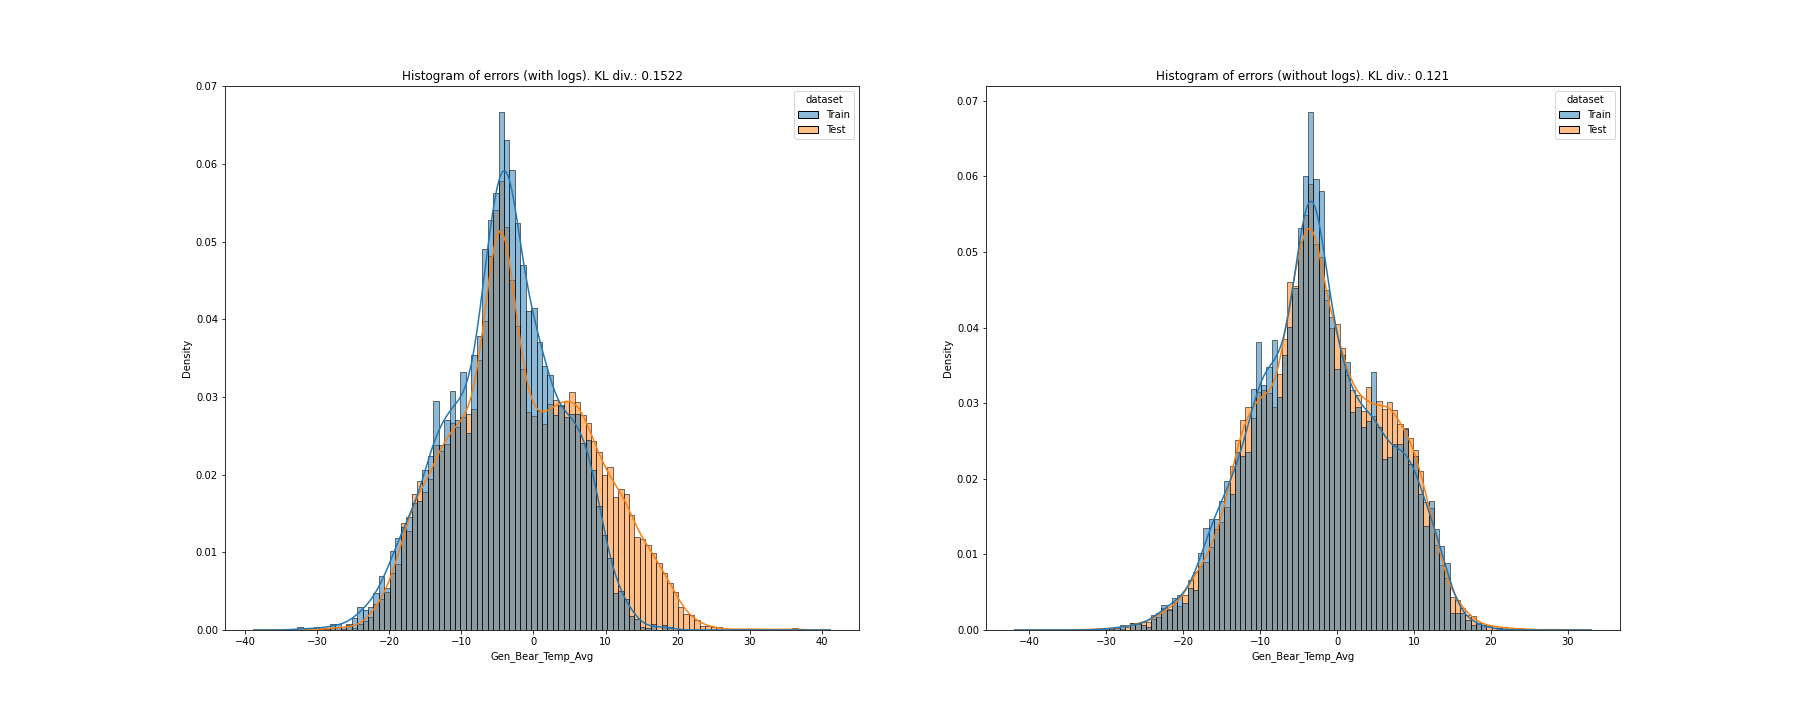

In [ ]:
#Distribution of errors
fig, axes = plt.subplots(1, 2, figsize=(25,10))
#fig = plt.figure(figsize=(15,10))
errors_train_2['dataset'] = 'Train'
errors_test_2['dataset'] = 'Test'

errors_train_2_x['dataset'] = 'Train'
errors_test_2_x['dataset'] = 'Test'

sns.histplot(pd.concat([errors_train_2, errors_test_2], ignore_index=True), x=y_column, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[0])
sns.histplot(pd.concat([errors_train_2_x, errors_test_2_x], ignore_index=True), x=y_column, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[1])

kl_logs = kl_divergence(np.histogram(errors_train_2[y_column], density=True)[0], np.histogram(errors_test_2[y_column], density=True)[0])
kl_no_logs = kl_divergence(np.histogram(errors_train_2_x[y_column], density=True)[0], np.histogram(errors_test_2_x[y_column], density=True)[0])

axes[0].set_title('Histogram of errors (with logs). KL div.: {}'.format(round(kl_logs, 4)));
axes[1].set_title('Histogram of errors (without logs). KL div.: {}'.format(round(kl_no_logs, 4)));

In [ ]:
#anomaly_threshold = errors_test_2[y_column].mean() + 3 * errors_test_2[y_column].std()
anomaly_threshold_2 = errors_train_2[y_column].mean() + 3 * errors_train_2[y_column].std()

Y_test_2['Anomaly'] = errors_test_2[y_column] > anomaly_threshold_2
Y_train_2['Anomaly'] = errors_train_2[y_column] > anomaly_threshold_2

anomaly_threshold_2_x = errors_train_2_x[y_column].mean() + 3 * errors_train_2_x[y_column].std()

Y_test_2_x['Anomaly'] = errors_test_2_x[y_column] > anomaly_threshold_2_x
Y_train_2_x['Anomaly'] = errors_train_2_x[y_column] > anomaly_threshold_2_x

In [ ]:
print(anomaly_threshold_2)
anomaly_threshold_2_x

19.304428914091623


22.13109240348273

In [ ]:
#Alarms
Y_test_2[Y_test_2['Anomaly']]

Gen_Bear_Temp_Avg  Anomaly
Timestamp                                            
2016-02-16 06:30:00+00:00               75.0     True
2016-02-20 08:40:00+00:00               86.0     True
2016-02-20 08:50:00+00:00               83.0     True
2016-02-21 01:10:00+00:00               78.0     True
2016-02-28 17:10:00+00:00               75.0     True
...                                      ...      ...
2016-09-29 19:10:00+00:00               97.0     True
2016-09-29 19:20:00+00:00               92.0     True
2016-10-03 11:50:00+00:00               66.0     True
2016-10-05 14:50:00+00:00               92.0     True
2016-10-05 15:00:00+00:00               90.0     True

[429 rows x 2 columns]

In [ ]:
relevant_logs = log_data_T01[log_data_T01.Remark.str.contains('bearing 1', na=False, case=False)]
Y_test_2['logs_found'] = None
for index, row in Y_test_2[Y_test_2.Anomaly].iterrows():
  filtered_logs = relevant_logs[(index - pd.Timedelta('24H')) : index]
  if not filtered_logs.empty:
    string = ''
    for i, r in filtered_logs.iterrows():
      string = string + r.Remark + ' @ ' + str(i) + '\n '
    Y_test_2.loc[index, 'logs_found'] = string

  else:
    Y_test_2.loc[index, 'logs_found'] = 'No logs found'

Y_test_2_x['logs_found'] = None
for index, row in Y_test_2_x[Y_test_2_x.Anomaly].iterrows():
  filtered_logs = relevant_logs[(index - pd.Timedelta('24H')) : index]
  if not filtered_logs.empty:
    string = ''
    for i, r in filtered_logs.iterrows():
      string = string + r.Remark + ' @ ' + str(i) + '\n '
    Y_test_2_x.loc[index, 'logs_found'] = string

  else:
    Y_test_2_x.loc[index, 'logs_found'] = 'No logs found'

In [ ]:
Y_test_2['date'] = pd.to_datetime(Y_test_2.index.date)
Y_test_2_x['date'] = pd.to_datetime(Y_test_2_x.index.date)


gt = Y_test_2
pr = Y_test_2

gt_2 = Y_test_2[Y_test_2.date.isin(list(Y_test_2[Y_test_2['Anomaly']].index.date))]
pr_2 = predictions_test_2[Y_test_2.date.isin(list(Y_test_2[Y_test_2['Anomaly']].index.date))]
x_2 = X_test_2[Y_test_2.date.isin(list(Y_test_2[Y_test_2['Anomaly']].index.date))]

gt_2.reset_index(inplace=True)
pr_2.reset_index(inplace=True)
x_2.reset_index(inplace=True)

gt_2.loc[gt_2['Timestamp'].diff().dt.total_seconds() > 600, y_column] = np.NAN
pr_2.loc[gt_2['Timestamp'].diff().dt.total_seconds() > 600, y_column] = np.NAN
x_2.loc[x_2['Timestamp'].diff().dt.total_seconds() > 600, 'Int_Vent'] = np.NAN

#=================================================================================

gt_2_x = Y_test_2_x[Y_test_2_x.date.isin(list(Y_test_2_x[Y_test_2_x['Anomaly']].index.date))]
pr_2_x = predictions_test_2_x[Y_test_2_x.date.isin(list(Y_test_2_x[Y_test_2_x['Anomaly']].index.date))]
x_2_x = X_test_2[Y_test_2_x.date.isin(list(Y_test_2_x[Y_test_2_x['Anomaly']].index.date))]

gt_2_x.reset_index(inplace=True)
pr_2_x.reset_index(inplace=True)
x_2_x.reset_index(inplace=True)

gt_2_x.loc[gt_2_x['Timestamp'].diff().dt.total_seconds() > 600, y_column] = np.NAN
pr_2_x.loc[gt_2_x['Timestamp'].diff().dt.total_seconds() > 600, y_column] = np.NAN
x_2_x.loc[x_2_x['Timestamp'].diff().dt.total_seconds() > 600, 'Int_Vent'] = np.NAN

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


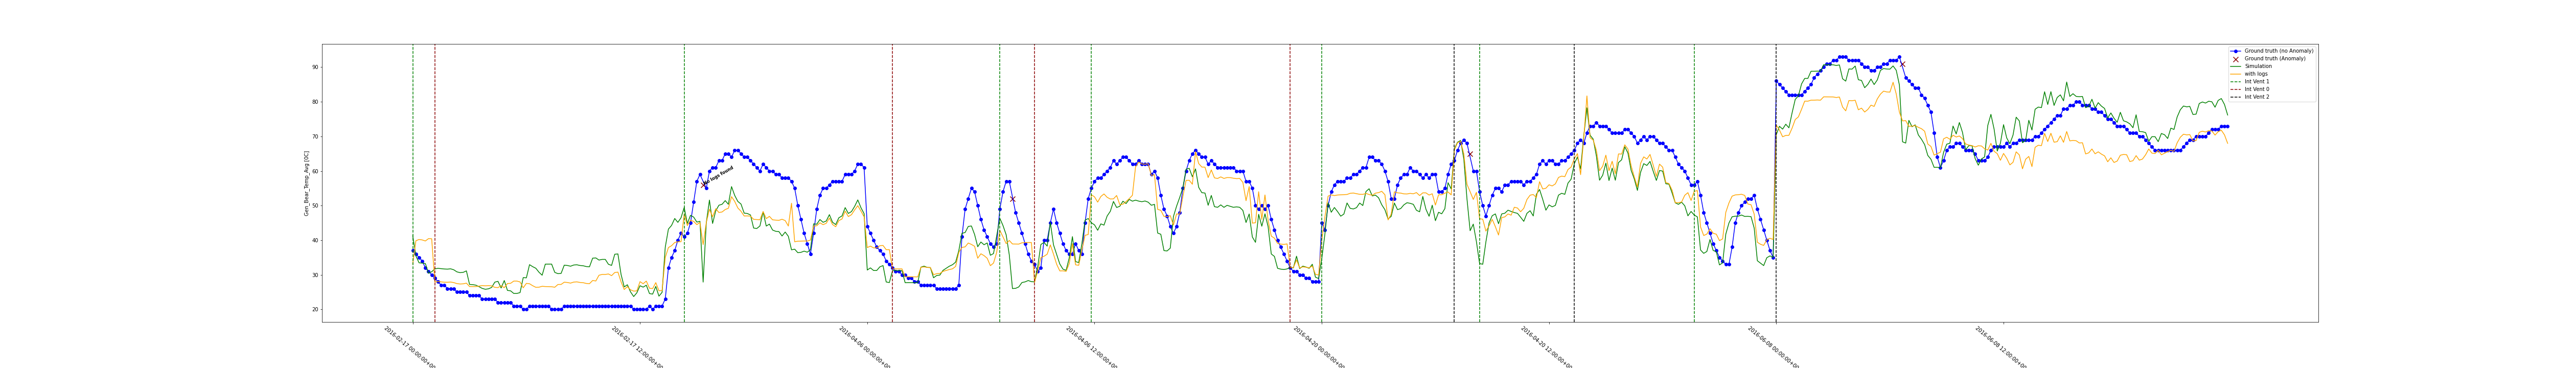

In [ ]:
ixes = (Y_test_2.date.isin(list(Y_test_2_x[Y_test_2_x['Anomaly']].index.date))) & ~(Y_test_2.date.isin(list(Y_test_2[Y_test_2['Anomaly']].index.date)))
gt_2_x_ex = Y_test_2_x[ixes].reset_index()
pr_2_ex = predictions_test_2[ixes].reset_index()
pr_2_x_ex = predictions_test_2_x[ixes].reset_index()
x_2_ex = X_test_2[ixes].reset_index()

plot_predicted_vs_true(pr_2_x_ex, gt_2_x_ex, y_column, hue='Anomaly', figsize=(70,10))
plt.plot(pr_2_ex.index, pr_2_ex[y_column], color='orange', label='with logs')

last_value = -1
for ix, row in x_2_ex.iterrows():
  if str(row.Int_Vent) == 'nan':
    plt.axvline(x=ix, linestyle='-', color='grey', label='Separator')
    last_value = -1
  if row.Int_Vent != last_value:
    if row.Int_Vent == 0.0:
      plt.axvline(x=ix, linestyle='--', color='darkred', label='Int Vent 0')
    elif row.Int_Vent == 1:
      plt.axvline(x=ix, linestyle='--', color='green', label='Int Vent 1')
    elif row.Int_Vent == 2:
      plt.axvline(x=ix, linestyle='--', color='black', label='Int Vent 2')
    
    last_value=row.Int_Vent

last_logs_found = ''
for line in range(0, gt_2_x_ex.shape[0], 1):
  if gt_2_x_ex.Anomaly[line] and gt_2_x_ex.logs_found[line] != last_logs_found:
    plt.text(gt_2_x_ex.index[line], gt_2_x_ex.Gen_Bear_Temp_Avg[line], gt_2_x_ex.logs_found[line], size='small', color='black', weight='semibold', rotation=30)
    #plt.axvline(x=gt.index[line], linestyle='--', color='black')
    last_logs_found = gt_2_x_ex.logs_found[line]

  elif gt_2_x_ex.logs_found[line] == 'Generator bearings replaced':
      plt.text(gt_2_x_ex.index[line], gt_2_x_ex.Gen_Bear_Temp_Avg[line], '!GENERATOR BEARINGS REPLACED!', size='medium', color='darkred', weight='bold', rotation=30)
      #plt.axvline(x=gt.index[line], linestyle='--', color='darkred')
plt.xticks(range(0, gt_2_x_ex.shape[0], 72), labels = gt_2_x_ex['Timestamp'][:-1:72], rotation=320);
plt.grid(False);

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());

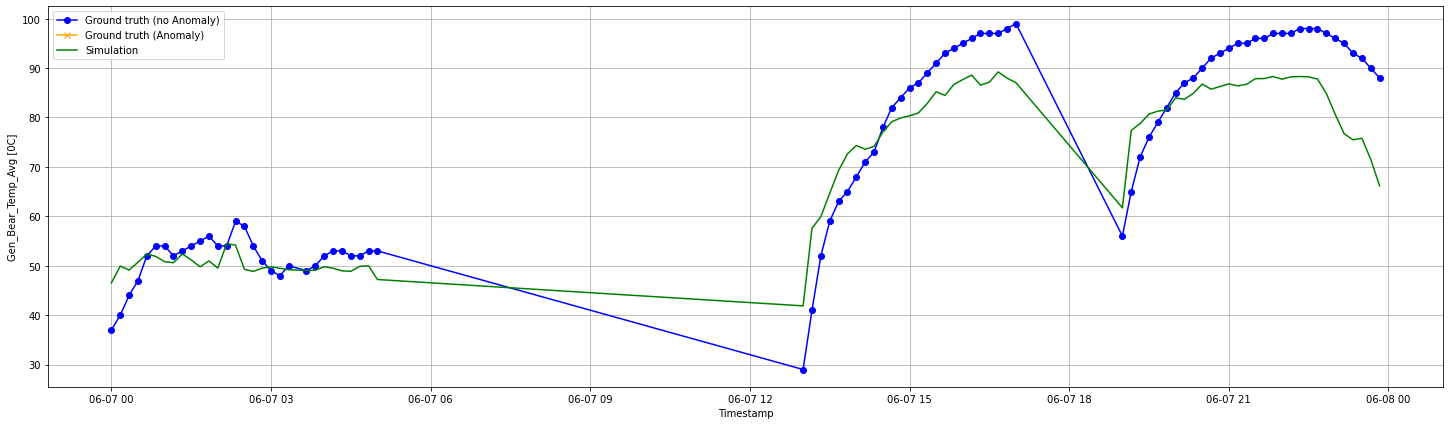

In [ ]:
#Failure 1: June 7, 2016 4:59 PM High temperature generator bearing
X_fail_2 = X_test_2.loc['2016-06-07':'2016-06-07']
Y_fail_2 = Y_test_2.loc['2016-06-07':'2016-06-07']
x_fail_2 = scaler_input.transform(X_fail_2)

plot_predicted_vs_true(pd.DataFrame(scaler_target.inverse_transform(model_2.predict(x_fail_2)), columns=[y_column], index=X_fail_2.index),Y_fail_2, y_column, hue='Anomaly')
#plot_error(pd.DataFrame(model_2.predict(X_fail_2), columns=[y_column], index=X_fail_2.index),Y_fail_2, y_column)

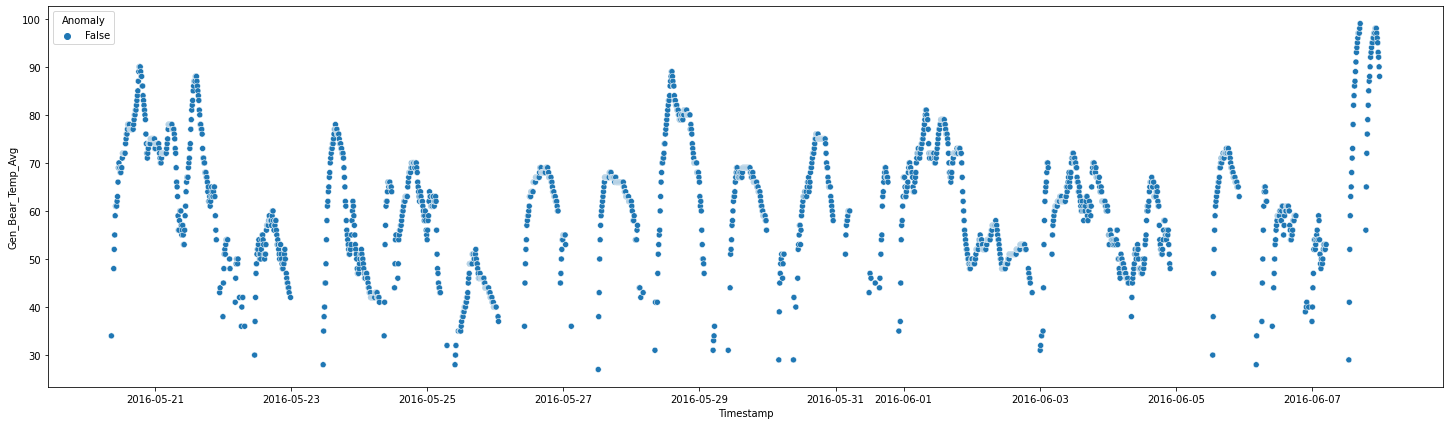

In [ ]:
#Before failure
fig = plt.figure(figsize=(25,7))
sns.scatterplot(x='Timestamp', y=y_column, hue='Anomaly', data=Y_test_2['2016-05-20':'2016-06-07'].reset_index())

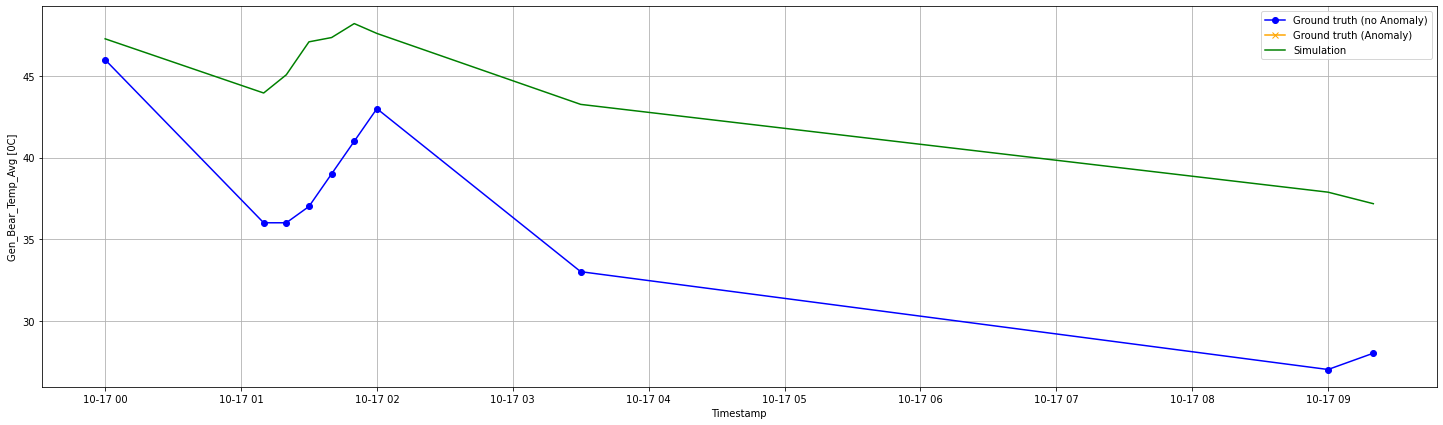

In [ ]:
#Failure 2: October 17, 2016 9:19 AM Generator bearings replaced
X_fail_2 = X_test_2.loc['2016-10-17':'2016-10-17']
Y_fail_2 = Y_test_2.loc['2016-10-17':'2016-10-17']
x_fail_2 = scaler_input.transform(X_fail_2)

plot_predicted_vs_true(pd.DataFrame(scaler_target.inverse_transform(model_2.predict(x_fail_2)), columns=[y_column], index=X_fail_2.index),Y_fail_2, y_column, hue='Anomaly')
#plot_error(pd.DataFrame(model_2.predict(X_fail_2), columns=[y_column], index=X_fail_2.index),Y_fail_2, y_column)

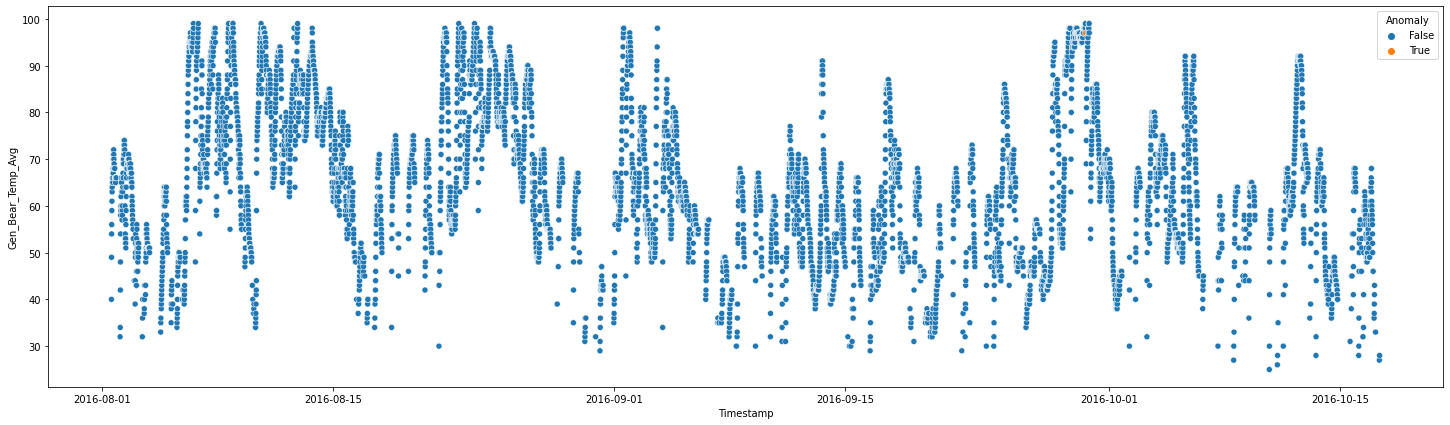

In [ ]:
#Before failure
fig = plt.figure(figsize=(25,7))
sns.scatterplot(x='Timestamp', y=y_column, hue='Anomaly', data=Y_test_2['2016-08-01':'2016-10-17'].reset_index())

**Compare error distributions of all turbines**

In [ ]:
combined_errors_train_2 = errors_train_2
combined_errors_train_2['turbine_id'] = 'T09'

combined_errors_test_2 = errors_test_2
combined_errors_test_2['turbine_id'] = 'T09'

In [ ]:
for t_id in ['T01', 'T06', 'T07', 'T11']:
  _, _, _, _, errors_train, _, _, _, errors_test, _, _, _ = \
                         implement_pipeline_mlp(all_data, train_date_start = train_start, train_date_end = '2016-09-30',
                                           test_date_start = '2016-10-01', test_date_end = '2018-01-01', y_column = y_column, turbine_id=t_id,
                         features=features, epochs=200, normalize=True)
  errors_train['turbine_id'] = t_id
  combined_errors_train_2 = pd.concat([combined_errors_train_2, errors_train], ignore_index=True)

  errors_test['turbine_id'] = t_id
  combined_errors_test_2 = pd.concat([combined_errors_test_2, errors_test], ignore_index=True)

Training model...
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 16)                80        
                                                                 
 dropout_25 (Dropout)        (None, 16)                0         
                                                                 
 dense_38 (Dense)            (None, 8)                 136       
                                                                 
 dropout_26 (Dropout)        (None, 8)                 0         
                                                                 
 dense_39 (Dense)            (None, 1)                 9         
                                                                 
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
393/393 - 2s - loss: 0.04

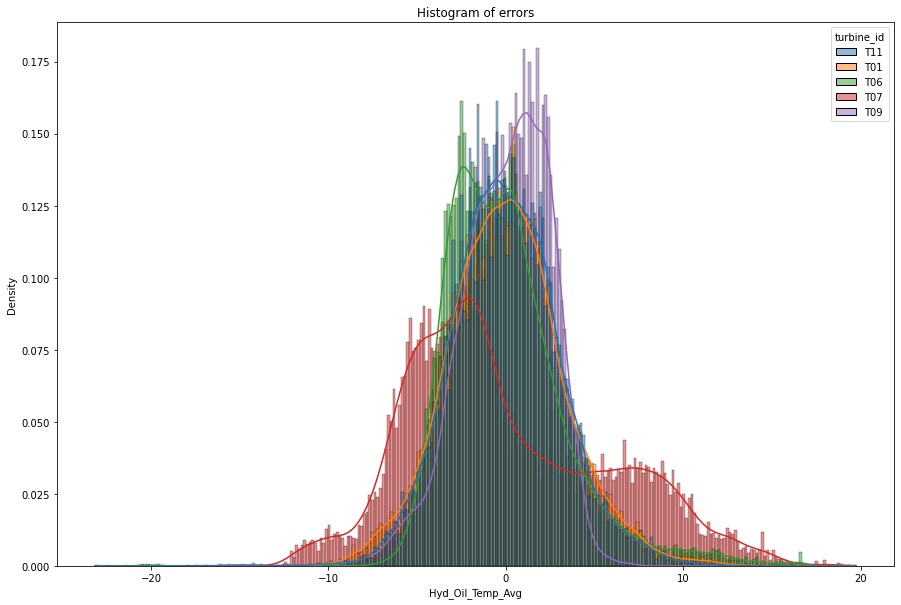

In [ ]:
fig = plt.figure(figsize=(15,10))
ax=sns.histplot(data=combined_errors_train_2, x=y_column, hue='turbine_id', kde=True, stat='density', common_norm=False)
ax.set_title('Histogram of errors');

**LSTM**

**Batch 1:** Train Jan-May, Test Jun-Nov

In [ ]:
dataset_3, X_train_3, Y_train_3, predictions_train_3, errors_train_3, X_test_3, Y_test_3, predictions_test_3, errors_test_3, model_3, scaler_input, scaler_target, x_train_reshaped_3, x_test_reshaped_3 = \
implement_pipeline_LSTM(T09_data, train_date_start = train_start, train_date_end = '2016-05-15', 
                        test_date_start = '2016-05-16', test_date_end = '2016-11-30', y_column = y_column, turbine_id='T09',
                        features=features, epochs=200, normalize=True, stateful=True, batch_size=100);

Training model...
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (10, 32)                  4864      
                                                                 
 dense_56 (Dense)            (10, 1)                   33        
                                                                 
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________
1271/1271 - 5s - loss: 0.0267 - 5s/epoch - 4ms/step
1271/1271 - 4s - loss: 0.0150 - 4s/epoch - 3ms/step
1271/1271 - 4s - loss: 0.0147 - 4s/epoch - 3ms/step
1271/1271 - 4s - loss: 0.0148 - 4s/epoch - 3ms/step
1271/1271 - 4s - loss: 0.0148 - 4s/epoch - 3ms/step
1271/1271 - 5s - loss: 0.0147 - 5s/epoch - 4ms/step
1271/1271 - 4s - loss: 0.0146 - 4s/epoch - 3ms/step
1271/1271 - 4s - loss: 0.0144 - 4s/epoch - 3ms/step
1271/1271 - 4

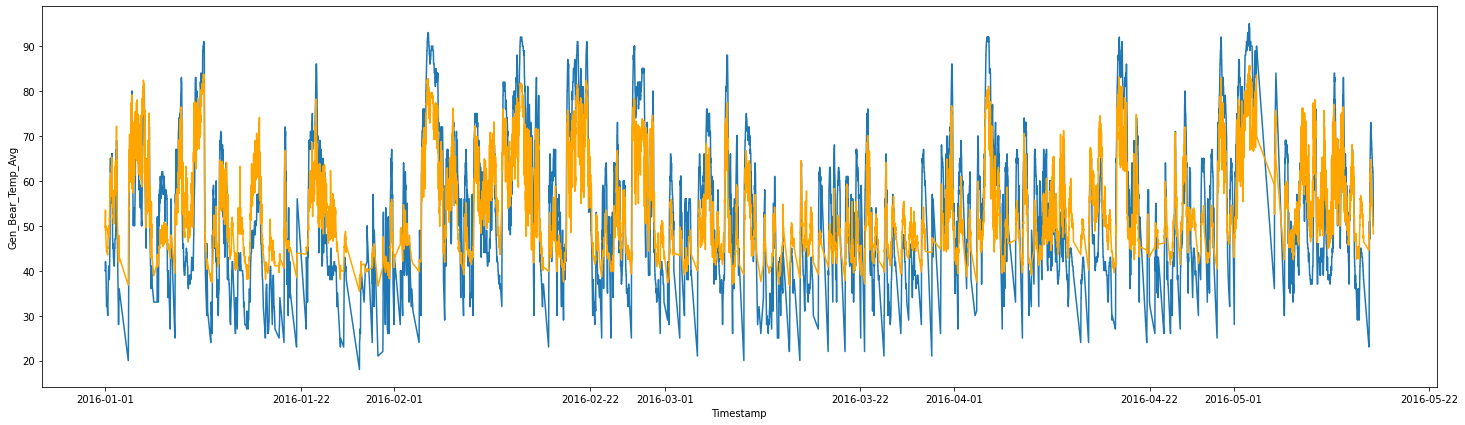

In [ ]:
plt.figure(figsize=(25,7))
sns.lineplot(x=Y_train_3.index, y=Y_train_3[y_column])
sns.lineplot(x=predictions_train_3.index, y=predictions_train_3[y_column], color='orange')

In [ ]:
Y_test_3['Anomaly'] = errors_test_3[y_column] > (errors_test_3[y_column].mean() + 3 * errors_test_3[y_column].std())

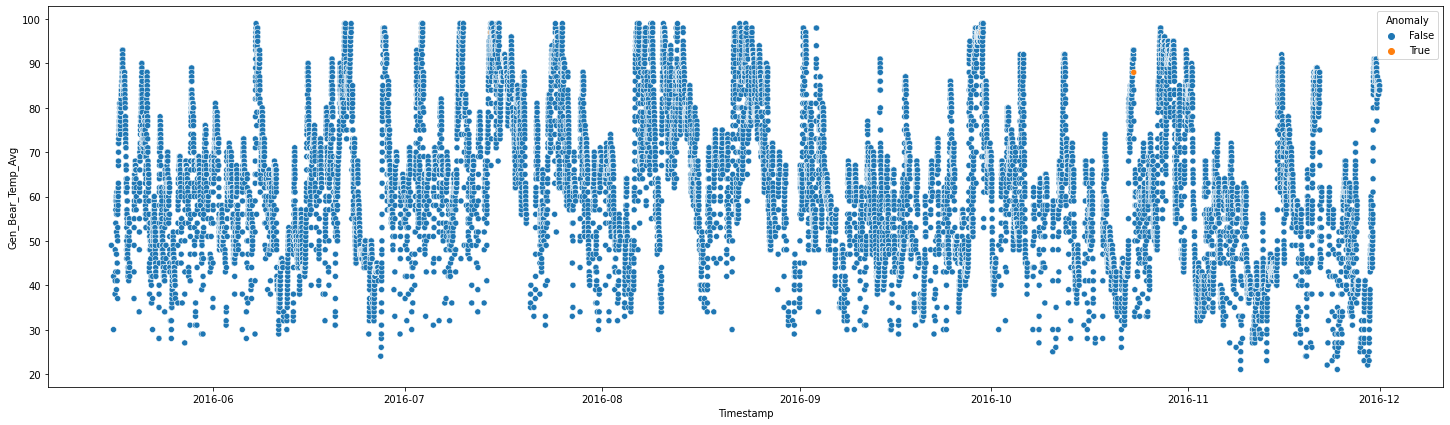

In [ ]:
fig = plt.figure(figsize=(25,7))
sns.scatterplot(x='Timestamp', y=y_column, hue='Anomaly', data=Y_test_3.reset_index())

In [ ]:
Y_test_3[Y_test_3.Anomaly]

Gen_Bear_Temp_Avg  Anomaly
Timestamp                                            
2016-06-21 16:30:00+00:00               97.0     True
2016-07-03 17:20:00+00:00               97.0     True
2016-07-14 12:50:00+00:00               97.0     True
2016-09-29 13:40:00+00:00               97.0     True
2016-10-23 10:10:00+00:00               88.0     True

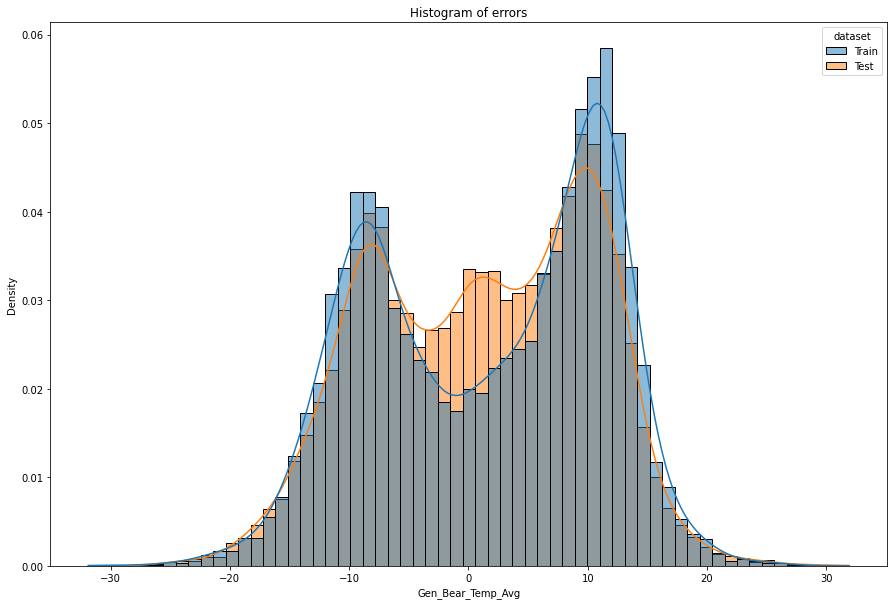

In [ ]:
#Distribution of errors
fig = plt.figure(figsize=(15,10))
errors_train_3['dataset'] = 'Train'
errors_test_3['dataset'] = 'Test'
ax=sns.histplot(pd.concat([errors_train_3, errors_test_3], ignore_index=True), x=y_column, hue='dataset', kde=True, stat='density', common_norm=False)
ax.set_title('Histogram of errors');

Text(0, 0.5, 'Gen Bear Temp Error [0C]')

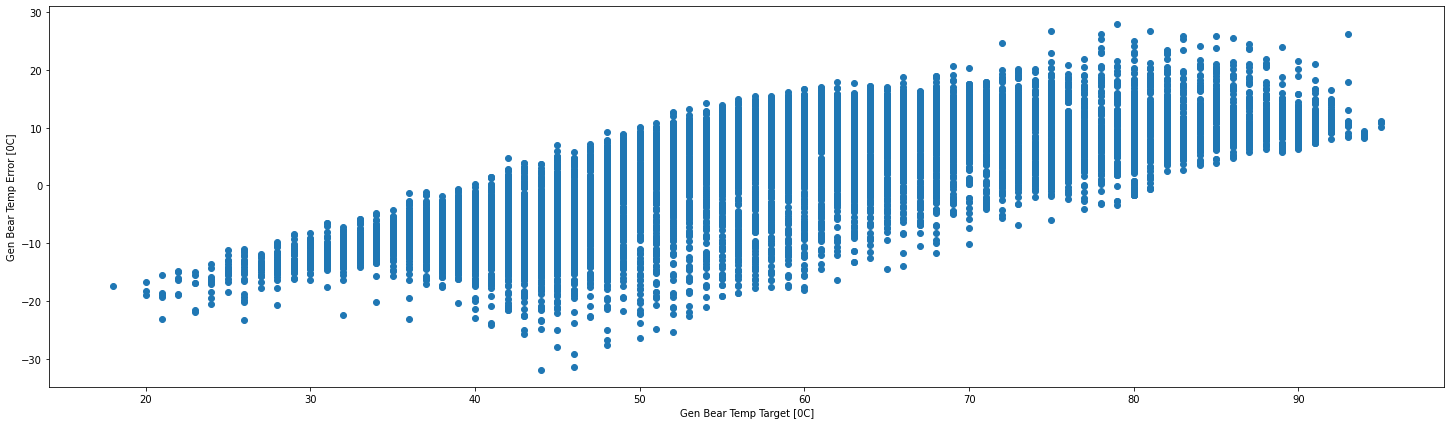

In [ ]:
#Error vs target
fig = plt.figure(figsize=(25,7))
plt.scatter(Y_train_3[y_column], errors_train_3[y_column])
plt.xlabel('Gen Bear Temp Target [0C]')
plt.ylabel('Gen Bear Temp Error [0C]')

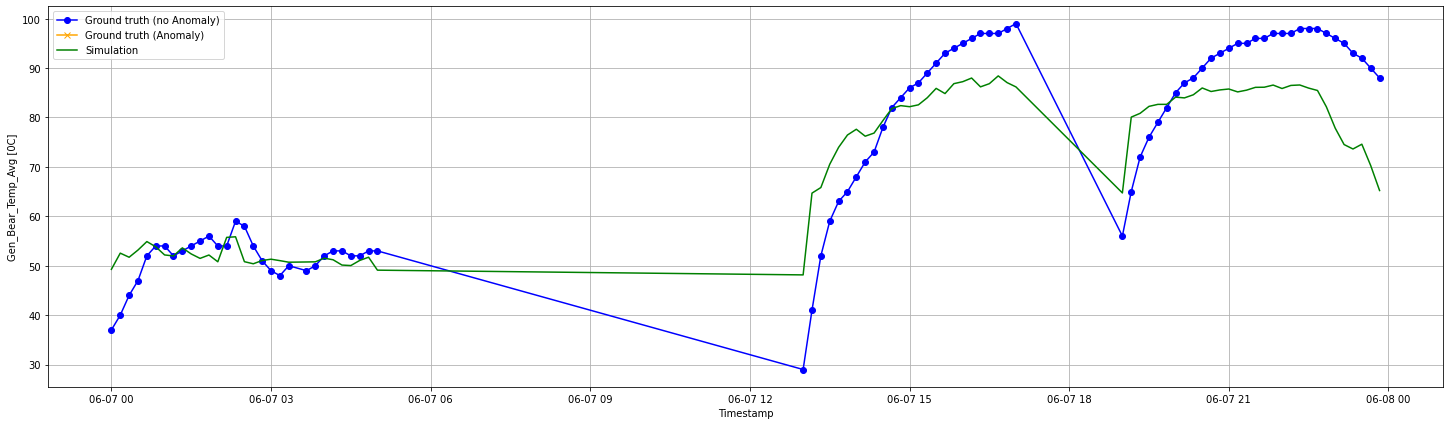

In [ ]:
#Failure 1: June 7, 2016 4:59 PM High temperature generator bearing
X_fail_1 = X_test_3.loc['2016-06-07':'2016-06-07']
Y_fail_1 = Y_test_3.loc['2016-06-07':'2016-06-07']
x_fail_1 = np.array(scaler_input.transform(X_fail_1)).reshape(x_fail_1.shape[0], 1, x_fail_1.shape[1])

plot_predicted_vs_true(pd.DataFrame(scaler_target.inverse_transform(model_3.predict(x_fail_1)), columns=[y_column], index=X_fail_1.index),Y_fail_1, y_column, hue='Anomaly')
#plot_error(pd.DataFrame(model_1.predict(X_fail_1), columns=[y_column], index=X_fail_1.index),Y_fail_1, y_column)

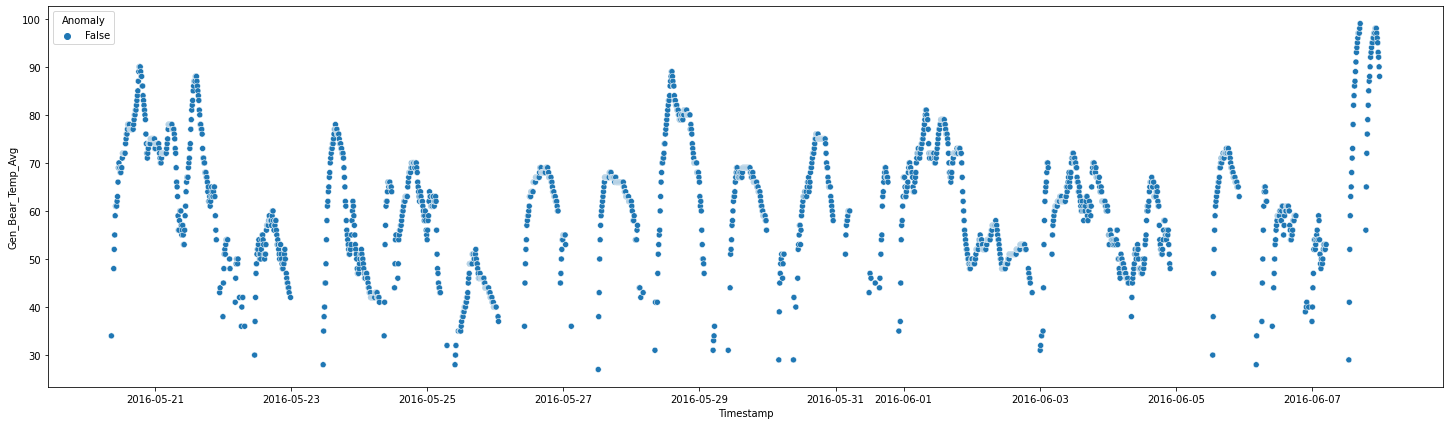

In [ ]:
#Before failure
fig = plt.figure(figsize=(25,7))
sns.scatterplot(x='Timestamp', y=y_column, hue='Anomaly', data=Y_test_3['2016-05-20':'2016-06-07'].reset_index())

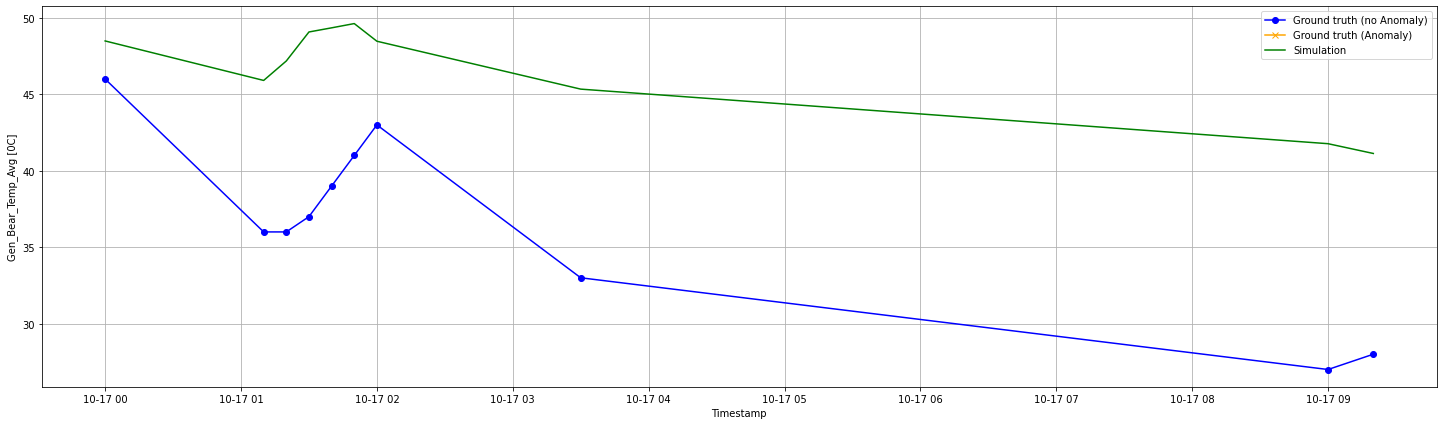

In [ ]:
#Failure 2: October 17, 2016 9:19 AM Generator bearings replaced
X_fail_ = X_test_3.loc['2016-10-17':'2016-10-17']
Y_fail_2 = Y_test_3.loc['2016-10-17':'2016-10-17']
x_fail_2 = np.array(scaler_input.transform(X_fail_2)).reshape(x_fail_2.shape[0], 1, x_fail_2.shape[1])

plot_predicted_vs_true(pd.DataFrame(scaler_target.inverse_transform(model_3.predict(x_fail_2)), columns=[y_column], index=X_fail_2.index),Y_fail_2, y_column, hue='Anomaly')
#plot_error(pd.DataFrame(model_1.predict(X_fail_2), columns=[y_column], index=X_fail_2.index),Y_fail_2, y_column)

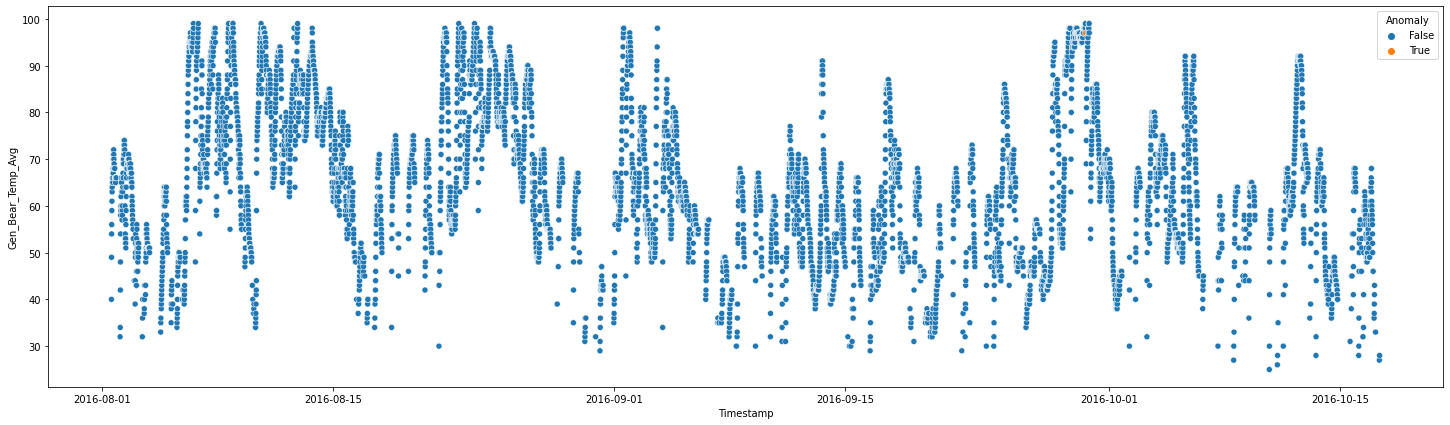

In [ ]:
#Before failure
fig = plt.figure(figsize=(25,7))
sns.scatterplot(x='Timestamp', y=y_column, hue='Anomaly', data=Y_test_3['2016-08-01':'2016-10-17'].reset_index())

**Compare error distributions of all turbines**

In [ ]:
combined_errors_train_2 = errors_train_2
combined_errors_train_2['turbine_id'] = 'T09'

combined_errors_test_2 = errors_test_2
combined_errors_test_2['turbine_id'] = 'T09'

In [ ]:
for t_id in ['T01', 'T06', 'T07', 'T09']:
  _, _, _, _, errors_train, _, _, _, errors_test, _, _, _ = \
                         implement_pipeline_mlp(all_data, train_date_start = train_start, train_date_end = '2016-09-30',
                                           test_date_start = '2016-10-01', test_date_end = '2018-01-01', y_column = y_column, turbine_id=t_id,
                         features=features, epochs=200, normalize=True)
  errors_train['turbine_id'] = t_id
  combined_errors_train_2 = pd.concat([combined_errors_train_2, errors_train], ignore_index=True)

  errors_test['turbine_id'] = t_id
  combined_errors_test_2 = pd.concat([combined_errors_test_2, errors_test], ignore_index=True)

In [ ]:
fig = plt.figure(figsize=(15,10))
ax=sns.histplot(data=combined_errors_train_2, x=y_column, hue='turbine_id', kde=True, stat='density', common_norm=False)
ax.set_title('Histogram of errors');